## Импорт библиотек и подготовка данных

In [355]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.stats import pearsonr
from sklearn.utils import shuffle
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.svm import LinearSVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore")
sns.set(context='notebook', style='whitegrid', palette='deep', 
        font='sans-serif', font_scale=1, color_codes=False, rc=None)

In [356]:
df = pd.read_csv('2. Cup_IT_2022_Датасет_Data_Science.csv')
df.fillna(0, inplace=True)

# Категории товаров
categories = ['Овощи - Фрукты', 'Рыба и рыбные изделия', 'Птица и изделия из птицы',
              'Сыры', 'Крупы и зерновые', 'Мясная гастрономия']

## Создание новых фичей

In [357]:
# Средний чек в месяце (и отдельно по категориям)
for month in range(6, 13):
    df['perc_'+str(month)] = df['rto_'+str(month)] / df['cnt_checks_'+str(month)]
    for cat in categories:
        df['perc_'+str(month)+'_'+cat] = df['rto_'+str(month)+'_'+cat] / df['cnt_checks_'+str(month)+'_'+cat]
df.fillna(0, inplace=True)

In [358]:
# Доля трат по каждой категории
for month in range(6, 13):
    for cat in categories:
        df['part_'+str(month)+'_'+cat] = df['rto_'+str(month)+'_'+cat] / df['rto_'+str(month)]
df.fillna(0, inplace=True)

In [359]:
# Доли трат по каждой категории (сумма по месяцам)   общие / члены клуба / не члены клуба
for cat in categories:
    month = 6
    print(cat, df['rto_'+str(month)+'_'+cat].sum() / df['rto_'+str(month)].sum(),
          df[df['is_in_club'] == 1]['rto_'+str(month)+'_'+cat].sum() / df[df['is_in_club'] == 1]['rto_'+str(month)].sum(),
          df[df['is_in_club'] == 0]['rto_'+str(month)+'_'+cat].sum() / df[df['is_in_club'] == 0]['rto_'+str(month)].sum())

Овощи - Фрукты 0.12373908745447526 0.13763981777166664 0.12154559249067129
Рыба и рыбные изделия 0.009255150879847351 0.009548638513223549 0.009208839381741869
Птица и изделия из птицы 0.03643104740242785 0.04040550620451369 0.035803889320277324
Сыры 0.04407113110188216 0.05068686048849137 0.04302718817512311
Крупы и зерновые 0.006401143159889142 0.006609659306708957 0.00636823991613975
Мясная гастрономия 0.05236371307785175 0.04914880416714641 0.05287101638809577


In [360]:
# Пытаемся скорректировать траты, чтобы понизить влияние роста цен
df["cor_6"] = df["rto_6_Овощи - Фрукты"]
df["cor_7"] = df["rto_7_Овощи - Фрукты"] / 1.0687
df["cor_8"] = df["rto_8_Овощи - Фрукты"] / 1.1526
df["cor_9"] = df["rto_9_Овощи - Фрукты"] / 1.1342
df["cor_10"] = df["rto_10_Овощи - Фрукты"] / 1.0477
df["cor_11"] = df["rto_11_Овощи - Фрукты"] / 1.0404
df["cor_12"] = df["rto_12_Овощи - Фрукты"] / 1.0049
df[["is_in_club", "cor_6", "cor_7", "cor_8", "cor_9", "cor_10", "cor_11", "cor_12"]].corr()

,is_in_club,cor_6,cor_7,cor_8,cor_9,cor_10,cor_11,cor_12
is_in_club,1.000000,0.116125,0.117106,0.119154,0.129658,0.143570,0.161603,0.170016
cor_6,0.116125,1.000000,0.670104,0.588891,0.538359,0.536181,0.518795,0.500849
cor_7,0.117106,0.670104,1.000000,0.657277,0.553803,0.530843,0.497019,0.473160
cor_8,0.119154,0.588891,0.657277,1.000000,0.652226,0.588579,0.539274,0.510362
cor_9,0.129658,0.538359,0.553803,0.652226,1.000000,0.702169,0.639922,0.589190
cor_10,0.143570,0.536181,0.530843,0.588579,0.702169,1.000000,0.744925,0.664042
cor_11,0.161603,0.518795,0.497019,0.539274,0.639922,0.744925,1.000000,0.734318
cor_12,0.170016,0.500849,0.473160,0.510362,0.589190,0.664042,0.734318,1.000000


In [361]:
df["mean_rto_Овощи - Фрукты"] = df[["rto_6_Овощи - Фрукты", "rto_7_Овощи - Фрукты", "rto_8_Овощи - Фрукты", "rto_9_Овощи - Фрукты", "rto_10_Овощи - Фрукты", "rto_11_Овощи - Фрукты", "rto_12_Овощи - Фрукты"]].mean(axis=1)
df["mean_cnt_checks_Овощи - Фрукты"] = df[["cnt_checks_6_Овощи - Фрукты", "cnt_checks_7_Овощи - Фрукты", "cnt_checks_8_Овощи - Фрукты", "cnt_checks_9_Овощи - Фрукты", "cnt_checks_10_Овощи - Фрукты", "cnt_checks_11_Овощи - Фрукты", "cnt_checks_12_Овощи - Фрукты"]].mean(axis=1)
df["mean_rto"] = df[["rto_6", "rto_7", "rto_8", "rto_9", "rto_10", "rto_11", "rto_12"]].mean(axis=1)
df["mean_cnt_checks"] = df[["cnt_checks_6", "cnt_checks_7", "cnt_checks_8", "cnt_checks_9", "cnt_checks_10", "cnt_checks_11", "cnt_checks_12"]].mean(axis=1)

In [362]:
fa = FactorAnalysis(n_components=1)

fa.fit(df[["rto_6_Овощи - Фрукты", "rto_7_Овощи - Фрукты", "rto_8_Овощи - Фрукты", "rto_9_Овощи - Фрукты", "rto_10_Овощи - Фрукты", "rto_11_Овощи - Фрукты", "rto_12_Овощи - Фрукты"]])
df["data1"] = fa.transform(df[["rto_6_Овощи - Фрукты", "rto_7_Овощи - Фрукты", "rto_8_Овощи - Фрукты", "rto_9_Овощи - Фрукты", "rto_10_Овощи - Фрукты", "rto_11_Овощи - Фрукты", "rto_12_Овощи - Фрукты"]])

fa.fit(df[["rto_6_Сыры", "rto_7_Сыры", "rto_8_Сыры", "rto_9_Сыры", "rto_10_Сыры", "rto_11_Сыры", "rto_12_Сыры"]])
df["data2"] = fa.transform(df[["rto_6_Сыры", "rto_7_Сыры", "rto_8_Сыры", "rto_9_Сыры", "rto_10_Сыры", "rto_11_Сыры", "rto_12_Сыры"]])

fa.fit(df[["rto_6_Птица и изделия из птицы", "rto_7_Птица и изделия из птицы", "rto_8_Птица и изделия из птицы", "rto_9_Птица и изделия из птицы", "rto_10_Птица и изделия из птицы", "rto_11_Птица и изделия из птицы", "rto_12_Птица и изделия из птицы"]])
df["data3"] = fa.transform(df[["rto_6_Птица и изделия из птицы", "rto_7_Птица и изделия из птицы", "rto_8_Птица и изделия из птицы", "rto_9_Птица и изделия из птицы", "rto_10_Птица и изделия из птицы", "rto_11_Птица и изделия из птицы", "rto_12_Птица и изделия из птицы"]])

fa.fit(df[["rto_6_Мясная гастрономия", "rto_7_Мясная гастрономия", "rto_8_Мясная гастрономия", "rto_9_Мясная гастрономия", "rto_10_Мясная гастрономия", "rto_11_Мясная гастрономия", "rto_12_Мясная гастрономия"]])
df["data4"] = fa.transform(df[["rto_6_Мясная гастрономия", "rto_7_Мясная гастрономия", "rto_8_Мясная гастрономия", "rto_9_Мясная гастрономия", "rto_10_Мясная гастрономия", "rto_11_Мясная гастрономия", "rto_12_Мясная гастрономия"]])

In [363]:
df.fillna(0, inplace=True)

## Первичный анализ

In [364]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135061 entries, 0 to 135060
Data columns (total 255 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   client_id                               135061 non-null  int64  
 1   is_in_club                              135061 non-null  int64  
 2   cnt_checks_10_Мясная гастрономия        135061 non-null  float64
 3   rto_std_11                              135061 non-null  float64
 4   rto_6                                   135061 non-null  float64
 5   rto_12_Сыры                             135061 non-null  float64
 6   rto_12_Птица и изделия из птицы         135061 non-null  float64
 7   rto_8                                   135061 non-null  float64
 8   cnt_checks_9                            135061 non-null  float64
 9   rto_9_Мясная гастрономия                135061 non-null  float64
 10  rto_10_Птица и изделия из птицы         135

In [365]:
# Людей, покупающих очень много товаров в месяц (либо на большие суммы) считаем исключениями (выбросами)
# Мы думаем, что многие из них являются перекупщиками и с ними лучше связываться индивидуально
for month in range(6, 13):
    df = df[df['cnt_checks_'+str(month)] <= 50]
    df = df[df['rto_'+str(month)] <= 80000]

In [366]:
print(f"Доля покупателей, находящихся в клубе {df['is_in_club'].sum() / df['is_in_club'].count()}")

Доля покупателей, находящихся в клубе 0.0906836114587158


In [367]:
df_in_club = df[df['is_in_club'] == 1]
df_notin_club = df[df['is_in_club'] == 0]

In [368]:
print('Медианные траты в месяце: \n')
for i in range(6, 13):
    s = 'rto_' + str(i)
    print(f'Месяц {i}, участники клуба {df_in_club[s].median()}, не члены клуба {df_notin_club[s].median()}')

Медианные траты в месяце: 

Месяц 6, участники клуба 4416.265722388382, не члены клуба 2590.964615074397
Месяц 7, участники клуба 4785.039054503917, не члены клуба 2732.198356819921
Месяц 8, участники клуба 5012.751395530478, не члены клуба 2816.933599342497
Месяц 9, участники клуба 5652.58674352534, не члены клуба 3086.4249536624707
Месяц 10, участники клуба 6413.974988712687, не члены клуба 3359.499442784423
Месяц 11, участники клуба 6888.149207626778, не члены клуба 3193.5343053087195
Месяц 12, участники клуба 8577.698151553323, не члены клуба 3983.8718633118983


## Визуализация

<AxesSubplot:xlabel='rto_6'>

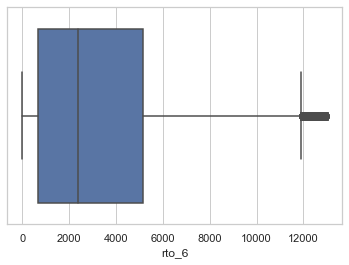

In [369]:
# Большинство людей закупается на суммы 1000-5000 рублей в месяц
# Также это может говорить о том, что многие покупают не в одной сети, а в разных
sns.boxplot(df[df['rto_6'] < 13000]['rto_6'])

<AxesSubplot:xlabel='cnt_checks_12', ylabel='Density'>

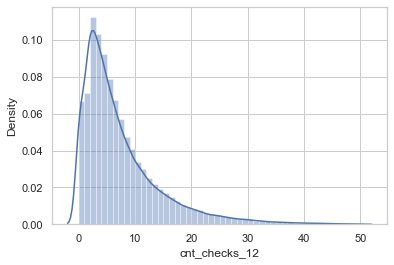

In [370]:
# Распределение количества чеков в декабре
sns.distplot(df['cnt_checks_12'])

In [371]:
# Масштабируем
df[list(df.columns)[2:]] = preprocessing.scale(df[list(df.columns)[2:]])

<AxesSubplot:>

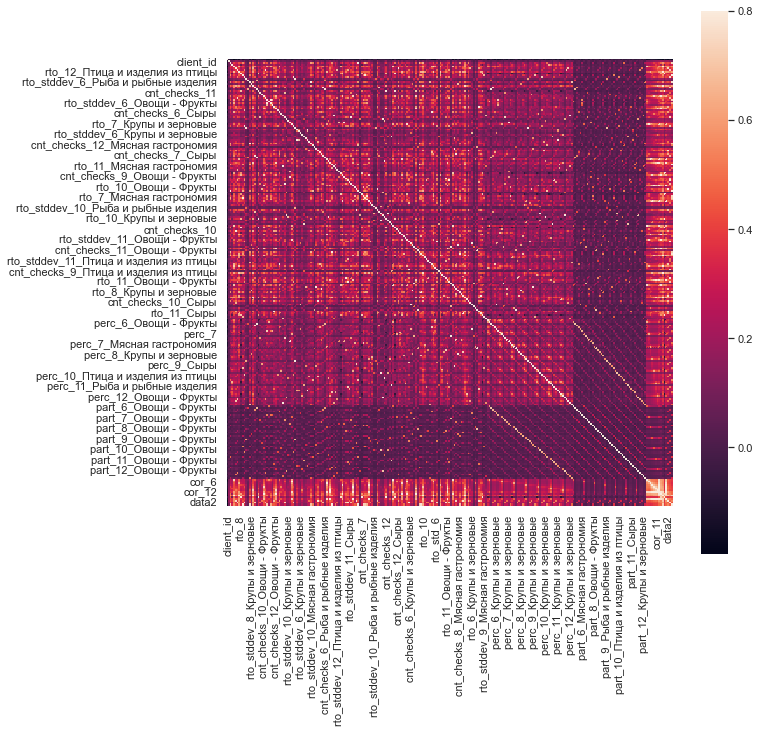

In [372]:
# Корреляции по всем признакам
corrmat = df.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=.8, square=True)

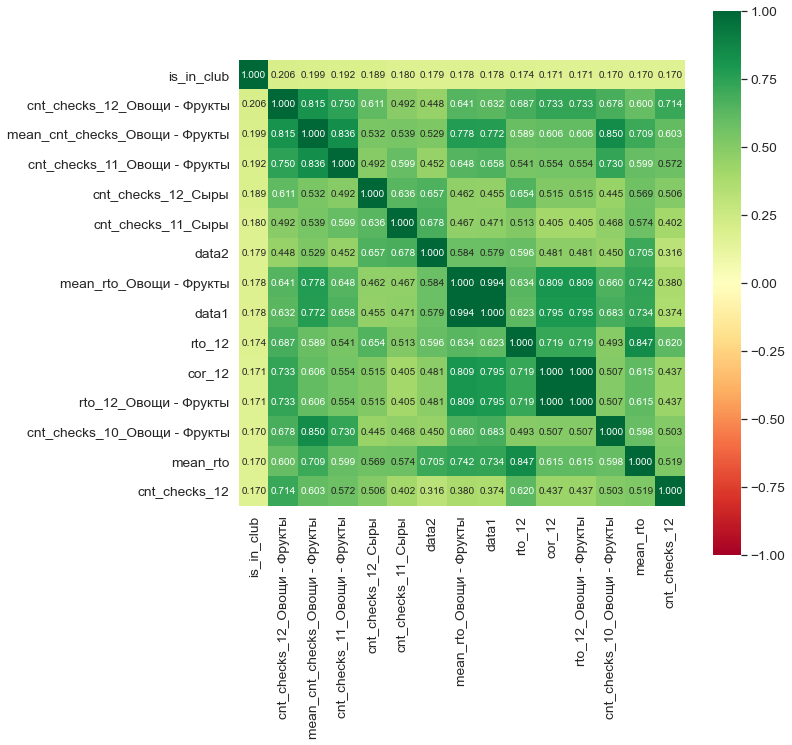

In [373]:
# Топ 15 корреляций с is_in_club
param = 'is_in_club'
k = 15
corrmat = df.corr()
cols = corrmat.nlargest(k, param)[param].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize = (10, 10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                fmt='.3f', annot_kws={'size': 10}, cmap='RdYlGn',
                center=0, vmax=1, vmin=-1,
                yticklabels=cols.values, xticklabels=cols.values)

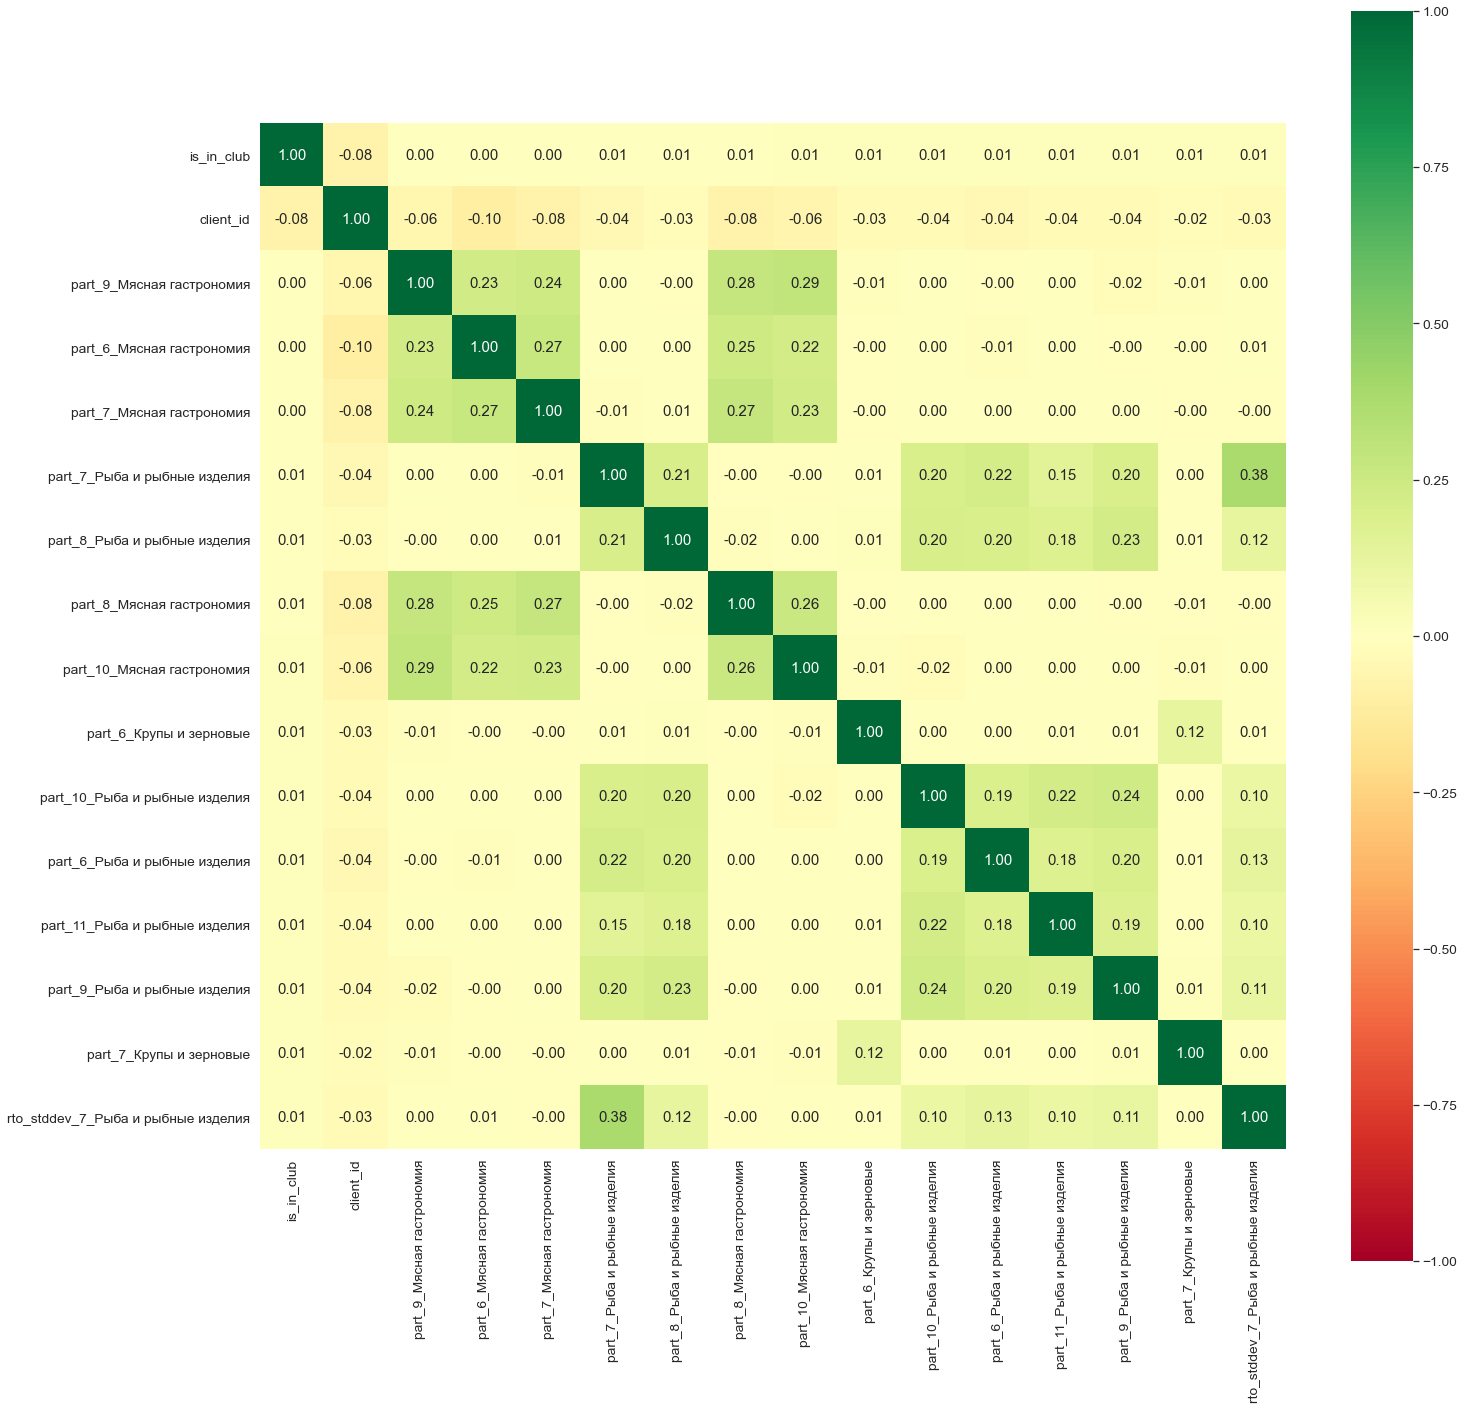

In [374]:
# Топ 15 обратных корреляций с is_in_club
param = 'is_in_club'
k = 15
h = [-1]
h.extend(list(range(k)))
corrmat = df.corr()
cols = corrmat.sort_values(by=param, ascending=True)[param][h].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize = (23, 23))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                fmt='.2f', annot_kws={'size': 15}, cmap='RdYlGn',
                center=0, vmax=1, vmin=-1,
                yticklabels=cols.values, xticklabels=cols.values)

<AxesSubplot:>

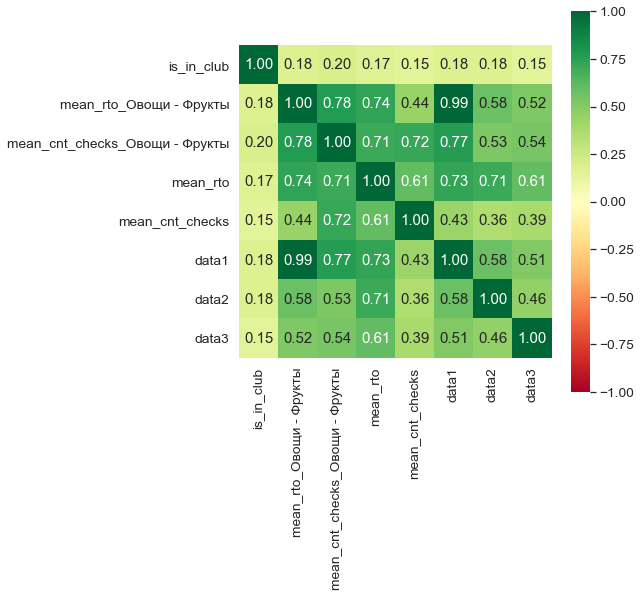

In [375]:
params = [
    "is_in_club", 
    "mean_rto_Овощи - Фрукты", 
    "mean_cnt_checks_Овощи - Фрукты", 
    "mean_rto",
    "mean_cnt_checks",
    "data1", 
    "data2", 
    "data3"
]
cm = df[params].corr()
f, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(cm, cbar=True, annot=True, square=True,
                fmt='.2f', annot_kws={'size': 15}, cmap='RdYlGn',
                center=0, vmax=1, vmin=-1)

## Тренировка модели и валидация

In [383]:
# Выделение тренировочной выборки
df1 = shuffle(df)
df_club = df1[df1["is_in_club"] == 1].iloc[:8000]
df1 = df1.drop(index = df_club.index)
df_not = df1[df1["is_in_club"] == 0].iloc[:8000]
df1 = df1.drop(index = df_not.index)
#по 8000 различных членов и не членов клуба
df_shuf = shuffle(pd.concat([df_club, df_not]))

#### Подбор параметров

In [377]:
# features = [
#     'cnt_checks_12_Овощи - Фрукты',
#     'cnt_checks_11_Овощи - Фрукты',
#     'cnt_checks_10_Овощи - Фрукты',
#     'cnt_checks_9_Овощи - Фрукты',
#     'cnt_checks_8_Овощи - Фрукты',
#     'cnt_checks_7_Овощи - Фрукты',
#     'cnt_checks_6_Овощи - Фрукты',
#     "data1",
#     'rto_12',
#     'rto_11',
#     'rto_10',
#     'rto_9',
#     'rto_8',
#     'rto_7',
#     'rto_6',
#     'cnt_checks_12_Сыры',
#     'cnt_checks_11_Сыры',
#     'cnt_checks_10_Сыры',
#     'cnt_checks_9_Сыры',
#     'cnt_checks_8_Сыры',
#     'cnt_checks_7_Сыры',
#     'cnt_checks_6_Сыры',
#     'data2',
#     'data3',
#     'data4'
# ]

# rec_score, prec_score, f_score, acur_score = 0, 0, 0, 0
# n = 10

# for i in range(n):
#     # Выделение тренировочной выборки
#     df1 = shuffle(df)
#     df_club = df1[df1["is_in_club"] == 1].iloc[:3000]
#     df1 = df1.drop(index = df_club.index)
#     df_not = df1[df1["is_in_club"] == 0].iloc[:3000]
#     df1 = df1.drop(index = df_not.index)
#     df1 = shuffle(pd.concat([df1[df1["is_in_club"] == 1].iloc[:1558],
#                              df1[df1["is_in_club"] == 0].iloc[:42710]]))
#     df_shuf = shuffle(pd.concat([df_club, df_not]))
    
#     train_x, val_x, train_y, val_y = df_shuf[features], df1[features], df_shuf['is_in_club'], df1['is_in_club']
#     print(train_x.shape)

    
# #     model = KNeighborsClassifier(n_neighbors=15, metric='euclidean')
# #     model.fit(train_x, train_y)
# #     pred = model.predict(val_x)

# #     model = DecisionTreeClassifier()
# #     model.fit(train_x, train_y)
# #     pred = model.predict(val_x)

# #     model = RandomForestClassifier(n_estimators=150, criterion='entropy', max_depth = 12)
# #     model.fit(train_x, train_y)
# #     pred = model.predict(val_x)

# #     model = LogisticRegression()
# #     model.fit(train_x, train_y)
# #     pred = model.predict(val_x)

# #     model = GaussianNB()
# #     model.fit(train_x, train_y)
# #     pred = model.predict(val_x)

# #     model = LinearSVC(loss='hinge', C=0.4, fit_intercept=True)
# #     model.fit(train_x, train_y)
# #     pred = model.predict(val_x)

# #     model = CatBoostClassifier()
# #     model.fit(train_x, train_y)
# #     pred = model.predict(val_x)

# #     model = XGBClassifier()
# #     model.fit(train_x, train_y)
# #     pred = model.predict(val_x)

# #     model = LGBMClassifier()
# #     model.fit(train_x, train_y)
# #     pred = model.predict(val_x)


#     rec_score += recall_score(pred, val_y, pos_label=1)
#     prec_score += precision_score(pred, val_y)
#     f_score += f1_score(pred, val_y, pos_label=1)
#     acur_score += accuracy_score(pred, val_y)

# print(f'Recall {rec_score / n}')
# print(f'Precision {prec_score / n}')
# print(f'F1 {f_score / n}')
# print(f'Accuracy {acur_score / n}')

In [384]:
# Итоговое тестирование
features = [
    'cnt_checks_12_Овощи - Фрукты',
    'cnt_checks_11_Овощи - Фрукты',
    'cnt_checks_10_Овощи - Фрукты',
    'cnt_checks_9_Овощи - Фрукты',
    'cnt_checks_8_Овощи - Фрукты',
    'cnt_checks_7_Овощи - Фрукты',
    'cnt_checks_6_Овощи - Фрукты',
    "data1",
    'rto_12',
    'rto_11',
    'rto_10',
    'rto_9',
    'rto_8',
    'rto_7',
    'rto_6',
    'cnt_checks_12_Сыры',
    'cnt_checks_11_Сыры',
    'cnt_checks_10_Сыры',
    'cnt_checks_9_Сыры',
    'cnt_checks_8_Сыры',
    'cnt_checks_7_Сыры',
    'cnt_checks_6_Сыры',
    'rto_12_Сыры',
    'rto_11_Сыры',
    'rto_10_Сыры',
    'rto_9_Сыры',
    'rto_8_Сыры',
    'rto_7_Сыры',
    'rto_6_Сыры',
    "mean_rto_Овощи - Фрукты",
    "mean_cnt_checks_Овощи - Фрукты",
    "mean_rto",
    "mean_cnt_checks"
]

# y = df['is_in_club']
# X = df[features]
# train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.3)

train_x, val_x, train_y, val_y = df_shuf[features], df1[features], df_shuf['is_in_club'], df1['is_in_club']

model = KNeighborsClassifier(n_neighbors=15, metric='euclidean')
model.fit(train_x, train_y)
knn_pred = model.predict(val_x)

model = DecisionTreeClassifier(random_state=20, min_impurity_decrease=0.01,
                               max_leaf_nodes=7, min_samples_split=0.7)
model.fit(train_x, train_y)
dt_pred = model.predict(val_x)

model = RandomForestClassifier(n_estimators=150, criterion='entropy', max_depth = 12)
model.fit(train_x, train_y)
rf_pred = model.predict(val_x)

model = LogisticRegression(random_state = 4, solver = 'newton-cg', penalty = 'l2')
model.fit(train_x, train_y)
lr_pred = model.predict(val_x)

model = GaussianNB()
model.fit(train_x, train_y)
nb_pred = model.predict(val_x)

model = LinearSVC(loss='hinge', C=0.4, fit_intercept=True)
model.fit(train_x, train_y)
svc_pred = model.predict(val_x)

model = CatBoostClassifier(iterations=9999)
model.fit(train_x, train_y)
cat_pred = model.predict(val_x)

model = XGBClassifier()
model.fit(train_x, train_y)
xgb_pred = model.predict(val_x)

model = LGBMClassifier()
model.fit(train_x, train_y)
lgbm_pred = model.predict(val_x)

Learning rate set to 0.004075
0:	learn: 0.6925662	total: 8.33ms	remaining: 1m 23s
1:	learn: 0.6919711	total: 16.6ms	remaining: 1m 23s
2:	learn: 0.6913793	total: 24.4ms	remaining: 1m 21s
3:	learn: 0.6908230	total: 32ms	remaining: 1m 20s
4:	learn: 0.6902502	total: 40ms	remaining: 1m 20s
5:	learn: 0.6896617	total: 48.1ms	remaining: 1m 20s
6:	learn: 0.6891107	total: 56.4ms	remaining: 1m 20s
7:	learn: 0.6885848	total: 64.4ms	remaining: 1m 20s
8:	learn: 0.6880120	total: 72.5ms	remaining: 1m 20s
9:	learn: 0.6874293	total: 80.6ms	remaining: 1m 20s
10:	learn: 0.6868946	total: 88.9ms	remaining: 1m 20s
11:	learn: 0.6863264	total: 96.7ms	remaining: 1m 20s
12:	learn: 0.6857925	total: 105ms	remaining: 1m 20s
13:	learn: 0.6852505	total: 113ms	remaining: 1m 20s
14:	learn: 0.6847032	total: 121ms	remaining: 1m 20s
15:	learn: 0.6841628	total: 128ms	remaining: 1m 20s
16:	learn: 0.6836235	total: 136ms	remaining: 1m 20s
17:	learn: 0.6830933	total: 144ms	remaining: 1m 20s
18:	learn: 0.6825692	total: 152ms	re

158:	learn: 0.6374628	total: 1.26s	remaining: 1m 17s
159:	learn: 0.6372912	total: 1.27s	remaining: 1m 17s
160:	learn: 0.6370952	total: 1.27s	remaining: 1m 17s
161:	learn: 0.6369211	total: 1.28s	remaining: 1m 17s
162:	learn: 0.6367417	total: 1.29s	remaining: 1m 17s
163:	learn: 0.6365656	total: 1.3s	remaining: 1m 17s
164:	learn: 0.6363626	total: 1.3s	remaining: 1m 17s
165:	learn: 0.6362017	total: 1.31s	remaining: 1m 17s
166:	learn: 0.6360341	total: 1.32s	remaining: 1m 17s
167:	learn: 0.6358446	total: 1.33s	remaining: 1m 17s
168:	learn: 0.6356681	total: 1.34s	remaining: 1m 17s
169:	learn: 0.6354881	total: 1.34s	remaining: 1m 17s
170:	learn: 0.6353204	total: 1.35s	remaining: 1m 17s
171:	learn: 0.6351566	total: 1.36s	remaining: 1m 17s
172:	learn: 0.6349823	total: 1.37s	remaining: 1m 17s
173:	learn: 0.6348099	total: 1.38s	remaining: 1m 17s
174:	learn: 0.6346332	total: 1.38s	remaining: 1m 17s
175:	learn: 0.6344758	total: 1.39s	remaining: 1m 17s
176:	learn: 0.6343122	total: 1.4s	remaining: 1m 

320:	learn: 0.6183449	total: 2.52s	remaining: 1m 16s
321:	learn: 0.6182814	total: 2.53s	remaining: 1m 16s
322:	learn: 0.6182083	total: 2.54s	remaining: 1m 16s
323:	learn: 0.6181318	total: 2.54s	remaining: 1m 16s
324:	learn: 0.6180617	total: 2.55s	remaining: 1m 16s
325:	learn: 0.6180005	total: 2.56s	remaining: 1m 16s
326:	learn: 0.6179365	total: 2.57s	remaining: 1m 16s
327:	learn: 0.6178584	total: 2.58s	remaining: 1m 16s
328:	learn: 0.6178045	total: 2.58s	remaining: 1m 16s
329:	learn: 0.6177488	total: 2.59s	remaining: 1m 15s
330:	learn: 0.6176834	total: 2.6s	remaining: 1m 15s
331:	learn: 0.6176144	total: 2.61s	remaining: 1m 15s
332:	learn: 0.6175440	total: 2.62s	remaining: 1m 15s
333:	learn: 0.6174749	total: 2.62s	remaining: 1m 15s
334:	learn: 0.6174057	total: 2.63s	remaining: 1m 15s
335:	learn: 0.6173440	total: 2.64s	remaining: 1m 15s
336:	learn: 0.6172825	total: 2.65s	remaining: 1m 15s
337:	learn: 0.6172160	total: 2.65s	remaining: 1m 15s
338:	learn: 0.6171472	total: 2.66s	remaining: 1

486:	learn: 0.6101100	total: 3.79s	remaining: 1m 14s
487:	learn: 0.6100775	total: 3.8s	remaining: 1m 14s
488:	learn: 0.6100474	total: 3.81s	remaining: 1m 14s
489:	learn: 0.6100065	total: 3.82s	remaining: 1m 14s
490:	learn: 0.6099712	total: 3.82s	remaining: 1m 14s
491:	learn: 0.6099370	total: 3.83s	remaining: 1m 14s
492:	learn: 0.6098993	total: 3.84s	remaining: 1m 14s
493:	learn: 0.6098627	total: 3.85s	remaining: 1m 14s
494:	learn: 0.6098220	total: 3.86s	remaining: 1m 14s
495:	learn: 0.6097884	total: 3.86s	remaining: 1m 14s
496:	learn: 0.6097558	total: 3.87s	remaining: 1m 14s
497:	learn: 0.6097325	total: 3.88s	remaining: 1m 14s
498:	learn: 0.6096929	total: 3.89s	remaining: 1m 14s
499:	learn: 0.6096734	total: 3.9s	remaining: 1m 14s
500:	learn: 0.6096503	total: 3.9s	remaining: 1m 13s
501:	learn: 0.6096122	total: 3.91s	remaining: 1m 13s
502:	learn: 0.6095858	total: 3.92s	remaining: 1m 13s
503:	learn: 0.6095552	total: 3.92s	remaining: 1m 13s
504:	learn: 0.6095125	total: 3.93s	remaining: 1m 

650:	learn: 0.6054780	total: 5.05s	remaining: 1m 12s
651:	learn: 0.6054476	total: 5.06s	remaining: 1m 12s
652:	learn: 0.6054178	total: 5.07s	remaining: 1m 12s
653:	learn: 0.6053932	total: 5.08s	remaining: 1m 12s
654:	learn: 0.6053710	total: 5.09s	remaining: 1m 12s
655:	learn: 0.6053514	total: 5.09s	remaining: 1m 12s
656:	learn: 0.6053202	total: 5.1s	remaining: 1m 12s
657:	learn: 0.6052974	total: 5.11s	remaining: 1m 12s
658:	learn: 0.6052715	total: 5.12s	remaining: 1m 12s
659:	learn: 0.6052455	total: 5.13s	remaining: 1m 12s
660:	learn: 0.6052161	total: 5.14s	remaining: 1m 12s
661:	learn: 0.6051912	total: 5.14s	remaining: 1m 12s
662:	learn: 0.6051541	total: 5.15s	remaining: 1m 12s
663:	learn: 0.6051243	total: 5.16s	remaining: 1m 12s
664:	learn: 0.6051021	total: 5.17s	remaining: 1m 12s
665:	learn: 0.6050764	total: 5.17s	remaining: 1m 12s
666:	learn: 0.6050611	total: 5.18s	remaining: 1m 12s
667:	learn: 0.6050368	total: 5.19s	remaining: 1m 12s
668:	learn: 0.6050123	total: 5.2s	remaining: 1m

816:	learn: 0.6017490	total: 6.32s	remaining: 1m 10s
817:	learn: 0.6017324	total: 6.32s	remaining: 1m 10s
818:	learn: 0.6017052	total: 6.33s	remaining: 1m 10s
819:	learn: 0.6016819	total: 6.34s	remaining: 1m 10s
820:	learn: 0.6016694	total: 6.34s	remaining: 1m 10s
821:	learn: 0.6016467	total: 6.35s	remaining: 1m 10s
822:	learn: 0.6016284	total: 6.36s	remaining: 1m 10s
823:	learn: 0.6016044	total: 6.37s	remaining: 1m 10s
824:	learn: 0.6015854	total: 6.38s	remaining: 1m 10s
825:	learn: 0.6015600	total: 6.38s	remaining: 1m 10s
826:	learn: 0.6015466	total: 6.39s	remaining: 1m 10s
827:	learn: 0.6015289	total: 6.4s	remaining: 1m 10s
828:	learn: 0.6014978	total: 6.41s	remaining: 1m 10s
829:	learn: 0.6014665	total: 6.41s	remaining: 1m 10s
830:	learn: 0.6014458	total: 6.42s	remaining: 1m 10s
831:	learn: 0.6014271	total: 6.43s	remaining: 1m 10s
832:	learn: 0.6014039	total: 6.44s	remaining: 1m 10s
833:	learn: 0.6013925	total: 6.44s	remaining: 1m 10s
834:	learn: 0.6013680	total: 6.45s	remaining: 1

981:	learn: 0.5986572	total: 7.58s	remaining: 1m 9s
982:	learn: 0.5986339	total: 7.58s	remaining: 1m 9s
983:	learn: 0.5986214	total: 7.59s	remaining: 1m 9s
984:	learn: 0.5986128	total: 7.6s	remaining: 1m 9s
985:	learn: 0.5985910	total: 7.61s	remaining: 1m 9s
986:	learn: 0.5985795	total: 7.61s	remaining: 1m 9s
987:	learn: 0.5985563	total: 7.62s	remaining: 1m 9s
988:	learn: 0.5985391	total: 7.63s	remaining: 1m 9s
989:	learn: 0.5985229	total: 7.63s	remaining: 1m 9s
990:	learn: 0.5985025	total: 7.64s	remaining: 1m 9s
991:	learn: 0.5984772	total: 7.65s	remaining: 1m 9s
992:	learn: 0.5984596	total: 7.66s	remaining: 1m 9s
993:	learn: 0.5984425	total: 7.67s	remaining: 1m 9s
994:	learn: 0.5984324	total: 7.67s	remaining: 1m 9s
995:	learn: 0.5984092	total: 7.68s	remaining: 1m 9s
996:	learn: 0.5983871	total: 7.69s	remaining: 1m 9s
997:	learn: 0.5983724	total: 7.7s	remaining: 1m 9s
998:	learn: 0.5983514	total: 7.7s	remaining: 1m 9s
999:	learn: 0.5983362	total: 7.71s	remaining: 1m 9s
1000:	learn: 0.

1149:	learn: 0.5956824	total: 8.84s	remaining: 1m 8s
1150:	learn: 0.5956677	total: 8.85s	remaining: 1m 8s
1151:	learn: 0.5956465	total: 8.85s	remaining: 1m 7s
1152:	learn: 0.5956239	total: 8.86s	remaining: 1m 7s
1153:	learn: 0.5956055	total: 8.87s	remaining: 1m 7s
1154:	learn: 0.5955879	total: 8.88s	remaining: 1m 7s
1155:	learn: 0.5955632	total: 8.88s	remaining: 1m 7s
1156:	learn: 0.5955470	total: 8.89s	remaining: 1m 7s
1157:	learn: 0.5955335	total: 8.9s	remaining: 1m 7s
1158:	learn: 0.5955189	total: 8.9s	remaining: 1m 7s
1159:	learn: 0.5954957	total: 8.91s	remaining: 1m 7s
1160:	learn: 0.5954765	total: 8.92s	remaining: 1m 7s
1161:	learn: 0.5954664	total: 8.93s	remaining: 1m 7s
1162:	learn: 0.5954574	total: 8.94s	remaining: 1m 7s
1163:	learn: 0.5954419	total: 8.94s	remaining: 1m 7s
1164:	learn: 0.5954324	total: 8.95s	remaining: 1m 7s
1165:	learn: 0.5954170	total: 8.96s	remaining: 1m 7s
1166:	learn: 0.5954002	total: 8.97s	remaining: 1m 7s
1167:	learn: 0.5953878	total: 8.97s	remaining: 1

1319:	learn: 0.5929269	total: 10.3s	remaining: 1m 7s
1320:	learn: 0.5929190	total: 10.3s	remaining: 1m 7s
1321:	learn: 0.5929122	total: 10.3s	remaining: 1m 7s
1322:	learn: 0.5928991	total: 10.3s	remaining: 1m 7s
1323:	learn: 0.5928897	total: 10.3s	remaining: 1m 7s
1324:	learn: 0.5928729	total: 10.3s	remaining: 1m 7s
1325:	learn: 0.5928493	total: 10.3s	remaining: 1m 7s
1326:	learn: 0.5928368	total: 10.3s	remaining: 1m 7s
1327:	learn: 0.5928271	total: 10.3s	remaining: 1m 7s
1328:	learn: 0.5928018	total: 10.3s	remaining: 1m 7s
1329:	learn: 0.5927914	total: 10.4s	remaining: 1m 7s
1330:	learn: 0.5927821	total: 10.4s	remaining: 1m 7s
1331:	learn: 0.5927719	total: 10.4s	remaining: 1m 7s
1332:	learn: 0.5927513	total: 10.4s	remaining: 1m 7s
1333:	learn: 0.5927299	total: 10.4s	remaining: 1m 7s
1334:	learn: 0.5927018	total: 10.4s	remaining: 1m 7s
1335:	learn: 0.5926821	total: 10.4s	remaining: 1m 7s
1336:	learn: 0.5926713	total: 10.4s	remaining: 1m 7s
1337:	learn: 0.5926476	total: 10.4s	remaining:

1476:	learn: 0.5905522	total: 11.5s	remaining: 1m 6s
1477:	learn: 0.5905426	total: 11.6s	remaining: 1m 6s
1478:	learn: 0.5905306	total: 11.6s	remaining: 1m 6s
1479:	learn: 0.5905163	total: 11.6s	remaining: 1m 6s
1480:	learn: 0.5905004	total: 11.6s	remaining: 1m 6s
1481:	learn: 0.5904826	total: 11.6s	remaining: 1m 6s
1482:	learn: 0.5904699	total: 11.6s	remaining: 1m 6s
1483:	learn: 0.5904538	total: 11.6s	remaining: 1m 6s
1484:	learn: 0.5904407	total: 11.6s	remaining: 1m 6s
1485:	learn: 0.5904248	total: 11.6s	remaining: 1m 6s
1486:	learn: 0.5904162	total: 11.6s	remaining: 1m 6s
1487:	learn: 0.5903958	total: 11.6s	remaining: 1m 6s
1488:	learn: 0.5903773	total: 11.6s	remaining: 1m 6s
1489:	learn: 0.5903699	total: 11.6s	remaining: 1m 6s
1490:	learn: 0.5903472	total: 11.6s	remaining: 1m 6s
1491:	learn: 0.5903254	total: 11.7s	remaining: 1m 6s
1492:	learn: 0.5903077	total: 11.7s	remaining: 1m 6s
1493:	learn: 0.5902880	total: 11.7s	remaining: 1m 6s
1494:	learn: 0.5902746	total: 11.7s	remaining:

1644:	learn: 0.5880917	total: 12.8s	remaining: 1m 5s
1645:	learn: 0.5880761	total: 12.8s	remaining: 1m 5s
1646:	learn: 0.5880536	total: 12.8s	remaining: 1m 5s
1647:	learn: 0.5880345	total: 12.8s	remaining: 1m 5s
1648:	learn: 0.5880161	total: 12.8s	remaining: 1m 5s
1649:	learn: 0.5880082	total: 12.8s	remaining: 1m 5s
1650:	learn: 0.5880020	total: 12.9s	remaining: 1m 5s
1651:	learn: 0.5879849	total: 12.9s	remaining: 1m 4s
1652:	learn: 0.5879738	total: 12.9s	remaining: 1m 4s
1653:	learn: 0.5879534	total: 12.9s	remaining: 1m 4s
1654:	learn: 0.5879380	total: 12.9s	remaining: 1m 4s
1655:	learn: 0.5879310	total: 12.9s	remaining: 1m 4s
1656:	learn: 0.5879182	total: 12.9s	remaining: 1m 4s
1657:	learn: 0.5879105	total: 12.9s	remaining: 1m 4s
1658:	learn: 0.5878900	total: 12.9s	remaining: 1m 4s
1659:	learn: 0.5878661	total: 12.9s	remaining: 1m 4s
1660:	learn: 0.5878459	total: 12.9s	remaining: 1m 4s
1661:	learn: 0.5878325	total: 12.9s	remaining: 1m 4s
1662:	learn: 0.5878226	total: 12.9s	remaining:

1810:	learn: 0.5857371	total: 14.1s	remaining: 1m 3s
1811:	learn: 0.5857213	total: 14.1s	remaining: 1m 3s
1812:	learn: 0.5857033	total: 14.1s	remaining: 1m 3s
1813:	learn: 0.5856972	total: 14.1s	remaining: 1m 3s
1814:	learn: 0.5856811	total: 14.1s	remaining: 1m 3s
1815:	learn: 0.5856687	total: 14.1s	remaining: 1m 3s
1816:	learn: 0.5856528	total: 14.1s	remaining: 1m 3s
1817:	learn: 0.5856375	total: 14.1s	remaining: 1m 3s
1818:	learn: 0.5856255	total: 14.1s	remaining: 1m 3s
1819:	learn: 0.5856111	total: 14.1s	remaining: 1m 3s
1820:	learn: 0.5856003	total: 14.1s	remaining: 1m 3s
1821:	learn: 0.5855926	total: 14.1s	remaining: 1m 3s
1822:	learn: 0.5855751	total: 14.2s	remaining: 1m 3s
1823:	learn: 0.5855697	total: 14.2s	remaining: 1m 3s
1824:	learn: 0.5855602	total: 14.2s	remaining: 1m 3s
1825:	learn: 0.5855532	total: 14.2s	remaining: 1m 3s
1826:	learn: 0.5855298	total: 14.2s	remaining: 1m 3s
1827:	learn: 0.5855082	total: 14.2s	remaining: 1m 3s
1828:	learn: 0.5854994	total: 14.2s	remaining:

1979:	learn: 0.5833727	total: 15.3s	remaining: 1m 2s
1980:	learn: 0.5833608	total: 15.3s	remaining: 1m 2s
1981:	learn: 0.5833447	total: 15.4s	remaining: 1m 2s
1982:	learn: 0.5833391	total: 15.4s	remaining: 1m 2s
1983:	learn: 0.5833175	total: 15.4s	remaining: 1m 2s
1984:	learn: 0.5833028	total: 15.4s	remaining: 1m 2s
1985:	learn: 0.5832863	total: 15.4s	remaining: 1m 2s
1986:	learn: 0.5832805	total: 15.4s	remaining: 1m 2s
1987:	learn: 0.5832603	total: 15.4s	remaining: 1m 2s
1988:	learn: 0.5832473	total: 15.4s	remaining: 1m 2s
1989:	learn: 0.5832264	total: 15.4s	remaining: 1m 2s
1990:	learn: 0.5832185	total: 15.4s	remaining: 1m 2s
1991:	learn: 0.5832010	total: 15.4s	remaining: 1m 2s
1992:	learn: 0.5831803	total: 15.4s	remaining: 1m 2s
1993:	learn: 0.5831610	total: 15.4s	remaining: 1m 1s
1994:	learn: 0.5831378	total: 15.4s	remaining: 1m 1s
1995:	learn: 0.5831208	total: 15.5s	remaining: 1m 1s
1996:	learn: 0.5830959	total: 15.5s	remaining: 1m 1s
1997:	learn: 0.5830835	total: 15.5s	remaining:

2146:	learn: 0.5809427	total: 16.6s	remaining: 1m
2147:	learn: 0.5809335	total: 16.6s	remaining: 1m
2148:	learn: 0.5809262	total: 16.6s	remaining: 1m
2149:	learn: 0.5808981	total: 16.6s	remaining: 1m
2150:	learn: 0.5808885	total: 16.6s	remaining: 1m
2151:	learn: 0.5808686	total: 16.6s	remaining: 1m
2152:	learn: 0.5808540	total: 16.6s	remaining: 1m
2153:	learn: 0.5808468	total: 16.7s	remaining: 1m
2154:	learn: 0.5808324	total: 16.7s	remaining: 1m
2155:	learn: 0.5808098	total: 16.7s	remaining: 1m
2156:	learn: 0.5807915	total: 16.7s	remaining: 1m
2157:	learn: 0.5807752	total: 16.7s	remaining: 1m
2158:	learn: 0.5807448	total: 16.7s	remaining: 1m
2159:	learn: 0.5807337	total: 16.7s	remaining: 1m
2160:	learn: 0.5807188	total: 16.7s	remaining: 1m
2161:	learn: 0.5807068	total: 16.7s	remaining: 1m
2162:	learn: 0.5806873	total: 16.7s	remaining: 1m
2163:	learn: 0.5806705	total: 16.7s	remaining: 1m
2164:	learn: 0.5806493	total: 16.7s	remaining: 1m
2165:	learn: 0.5806381	total: 16.7s	remaining: 1m


2313:	learn: 0.5783733	total: 17.9s	remaining: 59.3s
2314:	learn: 0.5783655	total: 17.9s	remaining: 59.3s
2315:	learn: 0.5783556	total: 17.9s	remaining: 59.3s
2316:	learn: 0.5783337	total: 17.9s	remaining: 59.3s
2317:	learn: 0.5783207	total: 17.9s	remaining: 59.3s
2318:	learn: 0.5783037	total: 17.9s	remaining: 59.3s
2319:	learn: 0.5782860	total: 17.9s	remaining: 59.2s
2320:	learn: 0.5782746	total: 17.9s	remaining: 59.2s
2321:	learn: 0.5782555	total: 17.9s	remaining: 59.2s
2322:	learn: 0.5782381	total: 17.9s	remaining: 59.2s
2323:	learn: 0.5782249	total: 17.9s	remaining: 59.2s
2324:	learn: 0.5782098	total: 17.9s	remaining: 59.2s
2325:	learn: 0.5781997	total: 17.9s	remaining: 59.2s
2326:	learn: 0.5781799	total: 18s	remaining: 59.2s
2327:	learn: 0.5781655	total: 18s	remaining: 59.2s
2328:	learn: 0.5781545	total: 18s	remaining: 59.2s
2329:	learn: 0.5781306	total: 18s	remaining: 59.2s
2330:	learn: 0.5781075	total: 18s	remaining: 59.2s
2331:	learn: 0.5780891	total: 18s	remaining: 59.1s
2332:

2481:	learn: 0.5756776	total: 19.1s	remaining: 57.9s
2482:	learn: 0.5756630	total: 19.1s	remaining: 57.9s
2483:	learn: 0.5756502	total: 19.1s	remaining: 57.9s
2484:	learn: 0.5756274	total: 19.1s	remaining: 57.9s
2485:	learn: 0.5756048	total: 19.1s	remaining: 57.9s
2486:	learn: 0.5755840	total: 19.2s	remaining: 57.9s
2487:	learn: 0.5755677	total: 19.2s	remaining: 57.9s
2488:	learn: 0.5755552	total: 19.2s	remaining: 57.8s
2489:	learn: 0.5755321	total: 19.2s	remaining: 57.8s
2490:	learn: 0.5755111	total: 19.2s	remaining: 57.8s
2491:	learn: 0.5754987	total: 19.2s	remaining: 57.8s
2492:	learn: 0.5754773	total: 19.2s	remaining: 57.8s
2493:	learn: 0.5754583	total: 19.2s	remaining: 57.8s
2494:	learn: 0.5754443	total: 19.2s	remaining: 57.8s
2495:	learn: 0.5754323	total: 19.2s	remaining: 57.8s
2496:	learn: 0.5754084	total: 19.2s	remaining: 57.8s
2497:	learn: 0.5754047	total: 19.2s	remaining: 57.8s
2498:	learn: 0.5753926	total: 19.2s	remaining: 57.8s
2499:	learn: 0.5753723	total: 19.3s	remaining:

2650:	learn: 0.5727229	total: 20.4s	remaining: 56.5s
2651:	learn: 0.5727068	total: 20.4s	remaining: 56.5s
2652:	learn: 0.5726954	total: 20.4s	remaining: 56.5s
2653:	learn: 0.5726716	total: 20.4s	remaining: 56.5s
2654:	learn: 0.5726459	total: 20.4s	remaining: 56.5s
2655:	learn: 0.5726290	total: 20.4s	remaining: 56.5s
2656:	learn: 0.5726015	total: 20.4s	remaining: 56.5s
2657:	learn: 0.5725911	total: 20.5s	remaining: 56.5s
2658:	learn: 0.5725803	total: 20.5s	remaining: 56.5s
2659:	learn: 0.5725703	total: 20.5s	remaining: 56.5s
2660:	learn: 0.5725526	total: 20.5s	remaining: 56.5s
2661:	learn: 0.5725410	total: 20.5s	remaining: 56.4s
2662:	learn: 0.5725244	total: 20.5s	remaining: 56.4s
2663:	learn: 0.5724946	total: 20.5s	remaining: 56.4s
2664:	learn: 0.5724837	total: 20.5s	remaining: 56.4s
2665:	learn: 0.5724668	total: 20.5s	remaining: 56.4s
2666:	learn: 0.5724426	total: 20.5s	remaining: 56.4s
2667:	learn: 0.5724371	total: 20.5s	remaining: 56.4s
2668:	learn: 0.5724243	total: 20.5s	remaining:

2815:	learn: 0.5697565	total: 21.7s	remaining: 55.3s
2816:	learn: 0.5697409	total: 21.7s	remaining: 55.3s
2817:	learn: 0.5697188	total: 21.7s	remaining: 55.3s
2818:	learn: 0.5696912	total: 21.7s	remaining: 55.3s
2819:	learn: 0.5696788	total: 21.7s	remaining: 55.2s
2820:	learn: 0.5696696	total: 21.7s	remaining: 55.2s
2821:	learn: 0.5696526	total: 21.7s	remaining: 55.2s
2822:	learn: 0.5696412	total: 21.7s	remaining: 55.2s
2823:	learn: 0.5696325	total: 21.7s	remaining: 55.2s
2824:	learn: 0.5696231	total: 21.7s	remaining: 55.2s
2825:	learn: 0.5696015	total: 21.7s	remaining: 55.2s
2826:	learn: 0.5695817	total: 21.8s	remaining: 55.2s
2827:	learn: 0.5695708	total: 21.8s	remaining: 55.2s
2828:	learn: 0.5695631	total: 21.8s	remaining: 55.2s
2829:	learn: 0.5695420	total: 21.8s	remaining: 55.2s
2830:	learn: 0.5695196	total: 21.8s	remaining: 55.2s
2831:	learn: 0.5695061	total: 21.8s	remaining: 55.1s
2832:	learn: 0.5694903	total: 21.8s	remaining: 55.1s
2833:	learn: 0.5694680	total: 21.8s	remaining:

2983:	learn: 0.5667068	total: 22.9s	remaining: 53.9s
2984:	learn: 0.5666902	total: 22.9s	remaining: 53.9s
2985:	learn: 0.5666783	total: 22.9s	remaining: 53.9s
2986:	learn: 0.5666651	total: 22.9s	remaining: 53.9s
2987:	learn: 0.5666542	total: 23s	remaining: 53.9s
2988:	learn: 0.5666399	total: 23s	remaining: 53.9s
2989:	learn: 0.5666312	total: 23s	remaining: 53.8s
2990:	learn: 0.5666080	total: 23s	remaining: 53.8s
2991:	learn: 0.5665856	total: 23s	remaining: 53.8s
2992:	learn: 0.5665801	total: 23s	remaining: 53.8s
2993:	learn: 0.5665663	total: 23s	remaining: 53.8s
2994:	learn: 0.5665544	total: 23s	remaining: 53.8s
2995:	learn: 0.5665369	total: 23s	remaining: 53.8s
2996:	learn: 0.5665203	total: 23s	remaining: 53.8s
2997:	learn: 0.5664928	total: 23s	remaining: 53.8s
2998:	learn: 0.5664835	total: 23s	remaining: 53.8s
2999:	learn: 0.5664709	total: 23s	remaining: 53.8s
3000:	learn: 0.5664498	total: 23.1s	remaining: 53.8s
3001:	learn: 0.5664376	total: 23.1s	remaining: 53.7s
3002:	learn: 0.5664

3155:	learn: 0.5636406	total: 24.2s	remaining: 52.5s
3156:	learn: 0.5636168	total: 24.2s	remaining: 52.5s
3157:	learn: 0.5636030	total: 24.2s	remaining: 52.5s
3158:	learn: 0.5635783	total: 24.2s	remaining: 52.5s
3159:	learn: 0.5635581	total: 24.2s	remaining: 52.4s
3160:	learn: 0.5635395	total: 24.2s	remaining: 52.4s
3161:	learn: 0.5635099	total: 24.2s	remaining: 52.4s
3162:	learn: 0.5634955	total: 24.3s	remaining: 52.4s
3163:	learn: 0.5634714	total: 24.3s	remaining: 52.4s
3164:	learn: 0.5634530	total: 24.3s	remaining: 52.4s
3165:	learn: 0.5634286	total: 24.3s	remaining: 52.4s
3166:	learn: 0.5634090	total: 24.3s	remaining: 52.4s
3167:	learn: 0.5633840	total: 24.3s	remaining: 52.4s
3168:	learn: 0.5633668	total: 24.3s	remaining: 52.4s
3169:	learn: 0.5633547	total: 24.3s	remaining: 52.4s
3170:	learn: 0.5633428	total: 24.3s	remaining: 52.4s
3171:	learn: 0.5633217	total: 24.3s	remaining: 52.3s
3172:	learn: 0.5633024	total: 24.3s	remaining: 52.3s
3173:	learn: 0.5632964	total: 24.3s	remaining:

3326:	learn: 0.5605199	total: 25.6s	remaining: 51.4s
3327:	learn: 0.5604981	total: 25.7s	remaining: 51.4s
3328:	learn: 0.5604812	total: 25.7s	remaining: 51.4s
3329:	learn: 0.5604641	total: 25.7s	remaining: 51.4s
3330:	learn: 0.5604430	total: 25.7s	remaining: 51.4s
3331:	learn: 0.5604212	total: 25.7s	remaining: 51.4s
3332:	learn: 0.5604144	total: 25.7s	remaining: 51.4s
3333:	learn: 0.5604035	total: 25.7s	remaining: 51.4s
3334:	learn: 0.5603863	total: 25.7s	remaining: 51.4s
3335:	learn: 0.5603614	total: 25.7s	remaining: 51.4s
3336:	learn: 0.5603432	total: 25.7s	remaining: 51.4s
3337:	learn: 0.5603287	total: 25.7s	remaining: 51.4s
3338:	learn: 0.5602946	total: 25.7s	remaining: 51.4s
3339:	learn: 0.5602723	total: 25.8s	remaining: 51.3s
3340:	learn: 0.5602611	total: 25.8s	remaining: 51.3s
3341:	learn: 0.5602385	total: 25.8s	remaining: 51.3s
3342:	learn: 0.5602277	total: 25.8s	remaining: 51.3s
3343:	learn: 0.5602097	total: 25.8s	remaining: 51.3s
3344:	learn: 0.5601910	total: 25.8s	remaining:

3482:	learn: 0.5577490	total: 26.9s	remaining: 50.3s
3483:	learn: 0.5577269	total: 26.9s	remaining: 50.3s
3484:	learn: 0.5577034	total: 26.9s	remaining: 50.3s
3485:	learn: 0.5576894	total: 26.9s	remaining: 50.3s
3486:	learn: 0.5576622	total: 26.9s	remaining: 50.3s
3487:	learn: 0.5576392	total: 26.9s	remaining: 50.3s
3488:	learn: 0.5576234	total: 27s	remaining: 50.3s
3489:	learn: 0.5575986	total: 27s	remaining: 50.3s
3490:	learn: 0.5575756	total: 27s	remaining: 50.3s
3491:	learn: 0.5575603	total: 27s	remaining: 50.3s
3492:	learn: 0.5575345	total: 27s	remaining: 50.3s
3493:	learn: 0.5575095	total: 27s	remaining: 50.3s
3494:	learn: 0.5574995	total: 27s	remaining: 50.3s
3495:	learn: 0.5574817	total: 27s	remaining: 50.2s
3496:	learn: 0.5574565	total: 27s	remaining: 50.2s
3497:	learn: 0.5574463	total: 27s	remaining: 50.2s
3498:	learn: 0.5574271	total: 27s	remaining: 50.2s
3499:	learn: 0.5574187	total: 27s	remaining: 50.2s
3500:	learn: 0.5574095	total: 27s	remaining: 50.2s
3501:	learn: 0.5573

3647:	learn: 0.5547583	total: 28.2s	remaining: 49s
3648:	learn: 0.5547357	total: 28.2s	remaining: 49s
3649:	learn: 0.5547181	total: 28.2s	remaining: 49s
3650:	learn: 0.5546933	total: 28.2s	remaining: 49s
3651:	learn: 0.5546686	total: 28.2s	remaining: 49s
3652:	learn: 0.5546384	total: 28.2s	remaining: 49s
3653:	learn: 0.5546180	total: 28.2s	remaining: 49s
3654:	learn: 0.5546003	total: 28.2s	remaining: 49s
3655:	learn: 0.5545758	total: 28.2s	remaining: 49s
3656:	learn: 0.5545621	total: 28.2s	remaining: 49s
3657:	learn: 0.5545470	total: 28.2s	remaining: 49s
3658:	learn: 0.5545345	total: 28.3s	remaining: 48.9s
3659:	learn: 0.5545238	total: 28.3s	remaining: 48.9s
3660:	learn: 0.5545101	total: 28.3s	remaining: 48.9s
3661:	learn: 0.5544924	total: 28.3s	remaining: 48.9s
3662:	learn: 0.5544662	total: 28.3s	remaining: 48.9s
3663:	learn: 0.5544575	total: 28.3s	remaining: 48.9s
3664:	learn: 0.5544435	total: 28.3s	remaining: 48.9s
3665:	learn: 0.5544279	total: 28.3s	remaining: 48.9s
3666:	learn: 0.

3816:	learn: 0.5518738	total: 29.4s	remaining: 47.7s
3817:	learn: 0.5518600	total: 29.4s	remaining: 47.7s
3818:	learn: 0.5518403	total: 29.4s	remaining: 47.7s
3819:	learn: 0.5518158	total: 29.5s	remaining: 47.6s
3820:	learn: 0.5517978	total: 29.5s	remaining: 47.6s
3821:	learn: 0.5517765	total: 29.5s	remaining: 47.6s
3822:	learn: 0.5517506	total: 29.5s	remaining: 47.6s
3823:	learn: 0.5517442	total: 29.5s	remaining: 47.6s
3824:	learn: 0.5517269	total: 29.5s	remaining: 47.6s
3825:	learn: 0.5517144	total: 29.5s	remaining: 47.6s
3826:	learn: 0.5517039	total: 29.5s	remaining: 47.6s
3827:	learn: 0.5516926	total: 29.5s	remaining: 47.6s
3828:	learn: 0.5516788	total: 29.5s	remaining: 47.6s
3829:	learn: 0.5516645	total: 29.5s	remaining: 47.6s
3830:	learn: 0.5516391	total: 29.5s	remaining: 47.5s
3831:	learn: 0.5516248	total: 29.5s	remaining: 47.5s
3832:	learn: 0.5516004	total: 29.5s	remaining: 47.5s
3833:	learn: 0.5515760	total: 29.6s	remaining: 47.5s
3834:	learn: 0.5515529	total: 29.6s	remaining:

3986:	learn: 0.5491213	total: 30.7s	remaining: 46.3s
3987:	learn: 0.5491037	total: 30.7s	remaining: 46.3s
3988:	learn: 0.5490863	total: 30.7s	remaining: 46.3s
3989:	learn: 0.5490650	total: 30.7s	remaining: 46.3s
3990:	learn: 0.5490444	total: 30.7s	remaining: 46.3s
3991:	learn: 0.5490280	total: 30.7s	remaining: 46.3s
3992:	learn: 0.5490126	total: 30.7s	remaining: 46.2s
3993:	learn: 0.5489915	total: 30.8s	remaining: 46.2s
3994:	learn: 0.5489730	total: 30.8s	remaining: 46.2s
3995:	learn: 0.5489619	total: 30.8s	remaining: 46.2s
3996:	learn: 0.5489516	total: 30.8s	remaining: 46.2s
3997:	learn: 0.5489382	total: 30.8s	remaining: 46.2s
3998:	learn: 0.5489206	total: 30.8s	remaining: 46.2s
3999:	learn: 0.5488922	total: 30.8s	remaining: 46.2s
4000:	learn: 0.5488807	total: 30.8s	remaining: 46.2s
4001:	learn: 0.5488655	total: 30.8s	remaining: 46.2s
4002:	learn: 0.5488472	total: 30.8s	remaining: 46.2s
4003:	learn: 0.5488266	total: 30.8s	remaining: 46.2s
4004:	learn: 0.5488098	total: 30.8s	remaining:

4152:	learn: 0.5463147	total: 32s	remaining: 45s
4153:	learn: 0.5462956	total: 32s	remaining: 45s
4154:	learn: 0.5462694	total: 32s	remaining: 45s
4155:	learn: 0.5462512	total: 32s	remaining: 45s
4156:	learn: 0.5462288	total: 32s	remaining: 45s
4157:	learn: 0.5462197	total: 32s	remaining: 45s
4158:	learn: 0.5461977	total: 32s	remaining: 44.9s
4159:	learn: 0.5461847	total: 32s	remaining: 44.9s
4160:	learn: 0.5461703	total: 32s	remaining: 44.9s
4161:	learn: 0.5461515	total: 32s	remaining: 44.9s
4162:	learn: 0.5461297	total: 32s	remaining: 44.9s
4163:	learn: 0.5461180	total: 32s	remaining: 44.9s
4164:	learn: 0.5460955	total: 32s	remaining: 44.9s
4165:	learn: 0.5460761	total: 32.1s	remaining: 44.9s
4166:	learn: 0.5460595	total: 32.1s	remaining: 44.9s
4167:	learn: 0.5460392	total: 32.1s	remaining: 44.9s
4168:	learn: 0.5460262	total: 32.1s	remaining: 44.9s
4169:	learn: 0.5460035	total: 32.1s	remaining: 44.9s
4170:	learn: 0.5459866	total: 32.1s	remaining: 44.8s
4171:	learn: 0.5459715	total: 3

4321:	learn: 0.5435341	total: 33.2s	remaining: 43.6s
4322:	learn: 0.5435105	total: 33.2s	remaining: 43.6s
4323:	learn: 0.5434908	total: 33.2s	remaining: 43.6s
4324:	learn: 0.5434647	total: 33.2s	remaining: 43.6s
4325:	learn: 0.5434431	total: 33.3s	remaining: 43.6s
4326:	learn: 0.5434297	total: 33.3s	remaining: 43.6s
4327:	learn: 0.5434186	total: 33.3s	remaining: 43.6s
4328:	learn: 0.5434033	total: 33.3s	remaining: 43.6s
4329:	learn: 0.5433824	total: 33.3s	remaining: 43.6s
4330:	learn: 0.5433764	total: 33.3s	remaining: 43.6s
4331:	learn: 0.5433614	total: 33.3s	remaining: 43.6s
4332:	learn: 0.5433483	total: 33.3s	remaining: 43.6s
4333:	learn: 0.5433374	total: 33.3s	remaining: 43.5s
4334:	learn: 0.5433190	total: 33.3s	remaining: 43.5s
4335:	learn: 0.5433043	total: 33.3s	remaining: 43.5s
4336:	learn: 0.5432900	total: 33.3s	remaining: 43.5s
4337:	learn: 0.5432734	total: 33.3s	remaining: 43.5s
4338:	learn: 0.5432571	total: 33.3s	remaining: 43.5s
4339:	learn: 0.5432449	total: 33.4s	remaining:

4488:	learn: 0.5408294	total: 34.5s	remaining: 42.3s
4489:	learn: 0.5408127	total: 34.5s	remaining: 42.3s
4490:	learn: 0.5407948	total: 34.5s	remaining: 42.3s
4491:	learn: 0.5407715	total: 34.5s	remaining: 42.3s
4492:	learn: 0.5407567	total: 34.5s	remaining: 42.3s
4493:	learn: 0.5407435	total: 34.5s	remaining: 42.3s
4494:	learn: 0.5407239	total: 34.5s	remaining: 42.3s
4495:	learn: 0.5407153	total: 34.5s	remaining: 42.3s
4496:	learn: 0.5407072	total: 34.5s	remaining: 42.3s
4497:	learn: 0.5406992	total: 34.5s	remaining: 42.3s
4498:	learn: 0.5406943	total: 34.6s	remaining: 42.2s
4499:	learn: 0.5406750	total: 34.6s	remaining: 42.2s
4500:	learn: 0.5406641	total: 34.6s	remaining: 42.2s
4501:	learn: 0.5406431	total: 34.6s	remaining: 42.2s
4502:	learn: 0.5406271	total: 34.6s	remaining: 42.2s
4503:	learn: 0.5406121	total: 34.6s	remaining: 42.2s
4504:	learn: 0.5405920	total: 34.6s	remaining: 42.2s
4505:	learn: 0.5405779	total: 34.6s	remaining: 42.2s
4506:	learn: 0.5405560	total: 34.6s	remaining:

4656:	learn: 0.5381872	total: 35.7s	remaining: 41s
4657:	learn: 0.5381672	total: 35.7s	remaining: 41s
4658:	learn: 0.5381460	total: 35.8s	remaining: 41s
4659:	learn: 0.5381241	total: 35.8s	remaining: 41s
4660:	learn: 0.5381093	total: 35.8s	remaining: 41s
4661:	learn: 0.5380900	total: 35.8s	remaining: 41s
4662:	learn: 0.5380795	total: 35.8s	remaining: 41s
4663:	learn: 0.5380680	total: 35.8s	remaining: 40.9s
4664:	learn: 0.5380444	total: 35.8s	remaining: 40.9s
4665:	learn: 0.5380293	total: 35.8s	remaining: 40.9s
4666:	learn: 0.5380131	total: 35.8s	remaining: 40.9s
4667:	learn: 0.5379948	total: 35.8s	remaining: 40.9s
4668:	learn: 0.5379821	total: 35.8s	remaining: 40.9s
4669:	learn: 0.5379621	total: 35.8s	remaining: 40.9s
4670:	learn: 0.5379359	total: 35.9s	remaining: 40.9s
4671:	learn: 0.5379181	total: 35.9s	remaining: 40.9s
4672:	learn: 0.5378968	total: 35.9s	remaining: 40.9s
4673:	learn: 0.5378720	total: 35.9s	remaining: 40.9s
4674:	learn: 0.5378527	total: 35.9s	remaining: 40.9s
4675:	l

4819:	learn: 0.5356210	total: 37s	remaining: 39.8s
4820:	learn: 0.5355995	total: 37s	remaining: 39.8s
4821:	learn: 0.5355826	total: 37s	remaining: 39.7s
4822:	learn: 0.5355672	total: 37s	remaining: 39.7s
4823:	learn: 0.5355484	total: 37s	remaining: 39.7s
4824:	learn: 0.5355391	total: 37s	remaining: 39.7s
4825:	learn: 0.5355204	total: 37s	remaining: 39.7s
4826:	learn: 0.5354965	total: 37.1s	remaining: 39.7s
4827:	learn: 0.5354727	total: 37.1s	remaining: 39.7s
4828:	learn: 0.5354557	total: 37.1s	remaining: 39.7s
4829:	learn: 0.5354404	total: 37.1s	remaining: 39.7s
4830:	learn: 0.5354170	total: 37.1s	remaining: 39.7s
4831:	learn: 0.5353954	total: 37.1s	remaining: 39.7s
4832:	learn: 0.5353763	total: 37.1s	remaining: 39.7s
4833:	learn: 0.5353551	total: 37.1s	remaining: 39.7s
4834:	learn: 0.5353354	total: 37.1s	remaining: 39.6s
4835:	learn: 0.5353277	total: 37.1s	remaining: 39.6s
4836:	learn: 0.5353096	total: 37.1s	remaining: 39.6s
4837:	learn: 0.5352979	total: 37.1s	remaining: 39.6s
4838:	l

4987:	learn: 0.5330197	total: 38.3s	remaining: 38.4s
4988:	learn: 0.5330046	total: 38.3s	remaining: 38.4s
4989:	learn: 0.5329810	total: 38.3s	remaining: 38.4s
4990:	learn: 0.5329671	total: 38.3s	remaining: 38.4s
4991:	learn: 0.5329506	total: 38.3s	remaining: 38.4s
4992:	learn: 0.5329417	total: 38.3s	remaining: 38.4s
4993:	learn: 0.5329226	total: 38.3s	remaining: 38.4s
4994:	learn: 0.5329091	total: 38.3s	remaining: 38.4s
4995:	learn: 0.5328823	total: 38.3s	remaining: 38.4s
4996:	learn: 0.5328642	total: 38.3s	remaining: 38.4s
4997:	learn: 0.5328457	total: 38.3s	remaining: 38.4s
4998:	learn: 0.5328285	total: 38.3s	remaining: 38.4s
4999:	learn: 0.5328163	total: 38.4s	remaining: 38.3s
5000:	learn: 0.5328001	total: 38.4s	remaining: 38.3s
5001:	learn: 0.5327850	total: 38.4s	remaining: 38.3s
5002:	learn: 0.5327760	total: 38.4s	remaining: 38.3s
5003:	learn: 0.5327649	total: 38.4s	remaining: 38.3s
5004:	learn: 0.5327580	total: 38.4s	remaining: 38.3s
5005:	learn: 0.5327433	total: 38.4s	remaining:

5155:	learn: 0.5304061	total: 39.5s	remaining: 37.1s
5156:	learn: 0.5303984	total: 39.5s	remaining: 37.1s
5157:	learn: 0.5303871	total: 39.5s	remaining: 37.1s
5158:	learn: 0.5303609	total: 39.5s	remaining: 37.1s
5159:	learn: 0.5303420	total: 39.6s	remaining: 37.1s
5160:	learn: 0.5303350	total: 39.6s	remaining: 37.1s
5161:	learn: 0.5303221	total: 39.6s	remaining: 37.1s
5162:	learn: 0.5303021	total: 39.6s	remaining: 37.1s
5163:	learn: 0.5302934	total: 39.6s	remaining: 37.1s
5164:	learn: 0.5302836	total: 39.6s	remaining: 37.1s
5165:	learn: 0.5302622	total: 39.6s	remaining: 37s
5166:	learn: 0.5302458	total: 39.6s	remaining: 37s
5167:	learn: 0.5302271	total: 39.6s	remaining: 37s
5168:	learn: 0.5302092	total: 39.6s	remaining: 37s
5169:	learn: 0.5301905	total: 39.6s	remaining: 37s
5170:	learn: 0.5301692	total: 39.6s	remaining: 37s
5171:	learn: 0.5301614	total: 39.6s	remaining: 37s
5172:	learn: 0.5301379	total: 39.7s	remaining: 37s
5173:	learn: 0.5301316	total: 39.7s	remaining: 37s
5174:	learn

5325:	learn: 0.5277747	total: 41s	remaining: 36s
5326:	learn: 0.5277543	total: 41s	remaining: 36s
5327:	learn: 0.5277432	total: 41s	remaining: 36s
5328:	learn: 0.5277275	total: 41s	remaining: 36s
5329:	learn: 0.5277130	total: 41s	remaining: 35.9s
5330:	learn: 0.5277064	total: 41s	remaining: 35.9s
5331:	learn: 0.5276951	total: 41.1s	remaining: 35.9s
5332:	learn: 0.5276727	total: 41.1s	remaining: 35.9s
5333:	learn: 0.5276663	total: 41.1s	remaining: 35.9s
5334:	learn: 0.5276552	total: 41.1s	remaining: 35.9s
5335:	learn: 0.5276375	total: 41.1s	remaining: 35.9s
5336:	learn: 0.5276163	total: 41.1s	remaining: 35.9s
5337:	learn: 0.5276010	total: 41.1s	remaining: 35.9s
5338:	learn: 0.5275853	total: 41.1s	remaining: 35.9s
5339:	learn: 0.5275617	total: 41.1s	remaining: 35.9s
5340:	learn: 0.5275547	total: 41.1s	remaining: 35.9s
5341:	learn: 0.5275422	total: 41.2s	remaining: 35.9s
5342:	learn: 0.5275200	total: 41.2s	remaining: 35.9s
5343:	learn: 0.5275026	total: 41.2s	remaining: 35.9s
5344:	learn: 

5483:	learn: 0.5254926	total: 42.2s	remaining: 34.8s
5484:	learn: 0.5254704	total: 42.3s	remaining: 34.8s
5485:	learn: 0.5254489	total: 42.3s	remaining: 34.8s
5486:	learn: 0.5254282	total: 42.3s	remaining: 34.8s
5487:	learn: 0.5254198	total: 42.3s	remaining: 34.7s
5488:	learn: 0.5254044	total: 42.3s	remaining: 34.7s
5489:	learn: 0.5253906	total: 42.3s	remaining: 34.7s
5490:	learn: 0.5253739	total: 42.3s	remaining: 34.7s
5491:	learn: 0.5253638	total: 42.3s	remaining: 34.7s
5492:	learn: 0.5253399	total: 42.3s	remaining: 34.7s
5493:	learn: 0.5253298	total: 42.3s	remaining: 34.7s
5494:	learn: 0.5253127	total: 42.3s	remaining: 34.7s
5495:	learn: 0.5252953	total: 42.3s	remaining: 34.7s
5496:	learn: 0.5252869	total: 42.3s	remaining: 34.7s
5497:	learn: 0.5252721	total: 42.4s	remaining: 34.7s
5498:	learn: 0.5252546	total: 42.4s	remaining: 34.7s
5499:	learn: 0.5252442	total: 42.4s	remaining: 34.7s
5500:	learn: 0.5252236	total: 42.4s	remaining: 34.6s
5501:	learn: 0.5252098	total: 42.4s	remaining:

5651:	learn: 0.5230897	total: 43.5s	remaining: 33.5s
5652:	learn: 0.5230785	total: 43.5s	remaining: 33.5s
5653:	learn: 0.5230561	total: 43.5s	remaining: 33.4s
5654:	learn: 0.5230448	total: 43.5s	remaining: 33.4s
5655:	learn: 0.5230270	total: 43.5s	remaining: 33.4s
5656:	learn: 0.5230002	total: 43.5s	remaining: 33.4s
5657:	learn: 0.5229961	total: 43.6s	remaining: 33.4s
5658:	learn: 0.5229763	total: 43.6s	remaining: 33.4s
5659:	learn: 0.5229583	total: 43.6s	remaining: 33.4s
5660:	learn: 0.5229481	total: 43.6s	remaining: 33.4s
5661:	learn: 0.5229335	total: 43.6s	remaining: 33.4s
5662:	learn: 0.5229173	total: 43.6s	remaining: 33.4s
5663:	learn: 0.5228927	total: 43.6s	remaining: 33.4s
5664:	learn: 0.5228826	total: 43.6s	remaining: 33.4s
5665:	learn: 0.5228739	total: 43.6s	remaining: 33.4s
5666:	learn: 0.5228603	total: 43.6s	remaining: 33.3s
5667:	learn: 0.5228459	total: 43.6s	remaining: 33.3s
5668:	learn: 0.5228243	total: 43.6s	remaining: 33.3s
5669:	learn: 0.5228083	total: 43.6s	remaining:

5819:	learn: 0.5207057	total: 44.8s	remaining: 32.1s
5820:	learn: 0.5206893	total: 44.8s	remaining: 32.1s
5821:	learn: 0.5206763	total: 44.8s	remaining: 32.1s
5822:	learn: 0.5206562	total: 44.8s	remaining: 32.1s
5823:	learn: 0.5206391	total: 44.8s	remaining: 32.1s
5824:	learn: 0.5206346	total: 44.8s	remaining: 32.1s
5825:	learn: 0.5206291	total: 44.8s	remaining: 32.1s
5826:	learn: 0.5206114	total: 44.8s	remaining: 32.1s
5827:	learn: 0.5205941	total: 44.8s	remaining: 32.1s
5828:	learn: 0.5205793	total: 44.8s	remaining: 32.1s
5829:	learn: 0.5205659	total: 44.8s	remaining: 32.1s
5830:	learn: 0.5205544	total: 44.8s	remaining: 32.1s
5831:	learn: 0.5205422	total: 44.9s	remaining: 32s
5832:	learn: 0.5205318	total: 44.9s	remaining: 32s
5833:	learn: 0.5205204	total: 44.9s	remaining: 32s
5834:	learn: 0.5204996	total: 44.9s	remaining: 32s
5835:	learn: 0.5204914	total: 44.9s	remaining: 32s
5836:	learn: 0.5204755	total: 44.9s	remaining: 32s
5837:	learn: 0.5204585	total: 44.9s	remaining: 32s
5838:	l

5986:	learn: 0.5183251	total: 46s	remaining: 30.8s
5987:	learn: 0.5183102	total: 46s	remaining: 30.8s
5988:	learn: 0.5182899	total: 46s	remaining: 30.8s
5989:	learn: 0.5182839	total: 46s	remaining: 30.8s
5990:	learn: 0.5182638	total: 46.1s	remaining: 30.8s
5991:	learn: 0.5182432	total: 46.1s	remaining: 30.8s
5992:	learn: 0.5182370	total: 46.1s	remaining: 30.8s
5993:	learn: 0.5182235	total: 46.1s	remaining: 30.8s
5994:	learn: 0.5182145	total: 46.1s	remaining: 30.8s
5995:	learn: 0.5181975	total: 46.1s	remaining: 30.8s
5996:	learn: 0.5181906	total: 46.1s	remaining: 30.8s
5997:	learn: 0.5181766	total: 46.1s	remaining: 30.8s
5998:	learn: 0.5181613	total: 46.1s	remaining: 30.8s
5999:	learn: 0.5181497	total: 46.1s	remaining: 30.7s
6000:	learn: 0.5181386	total: 46.1s	remaining: 30.7s
6001:	learn: 0.5181219	total: 46.1s	remaining: 30.7s
6002:	learn: 0.5181104	total: 46.1s	remaining: 30.7s
6003:	learn: 0.5180996	total: 46.2s	remaining: 30.7s
6004:	learn: 0.5180779	total: 46.2s	remaining: 30.7s
6

6153:	learn: 0.5159815	total: 47.3s	remaining: 29.5s
6154:	learn: 0.5159653	total: 47.3s	remaining: 29.5s
6155:	learn: 0.5159415	total: 47.3s	remaining: 29.5s
6156:	learn: 0.5159244	total: 47.3s	remaining: 29.5s
6157:	learn: 0.5159048	total: 47.3s	remaining: 29.5s
6158:	learn: 0.5158943	total: 47.3s	remaining: 29.5s
6159:	learn: 0.5158811	total: 47.3s	remaining: 29.5s
6160:	learn: 0.5158630	total: 47.3s	remaining: 29.5s
6161:	learn: 0.5158489	total: 47.3s	remaining: 29.5s
6162:	learn: 0.5158295	total: 47.4s	remaining: 29.5s
6163:	learn: 0.5158086	total: 47.4s	remaining: 29.5s
6164:	learn: 0.5157985	total: 47.4s	remaining: 29.5s
6165:	learn: 0.5157880	total: 47.4s	remaining: 29.4s
6166:	learn: 0.5157765	total: 47.4s	remaining: 29.4s
6167:	learn: 0.5157605	total: 47.4s	remaining: 29.4s
6168:	learn: 0.5157488	total: 47.4s	remaining: 29.4s
6169:	learn: 0.5157299	total: 47.4s	remaining: 29.4s
6170:	learn: 0.5157199	total: 47.4s	remaining: 29.4s
6171:	learn: 0.5157018	total: 47.4s	remaining:

6320:	learn: 0.5136071	total: 48.5s	remaining: 28.2s
6321:	learn: 0.5135905	total: 48.6s	remaining: 28.2s
6322:	learn: 0.5135760	total: 48.6s	remaining: 28.2s
6323:	learn: 0.5135690	total: 48.6s	remaining: 28.2s
6324:	learn: 0.5135562	total: 48.6s	remaining: 28.2s
6325:	learn: 0.5135407	total: 48.6s	remaining: 28.2s
6326:	learn: 0.5135281	total: 48.6s	remaining: 28.2s
6327:	learn: 0.5135148	total: 48.6s	remaining: 28.2s
6328:	learn: 0.5135012	total: 48.6s	remaining: 28.2s
6329:	learn: 0.5134803	total: 48.6s	remaining: 28.2s
6330:	learn: 0.5134597	total: 48.6s	remaining: 28.2s
6331:	learn: 0.5134407	total: 48.6s	remaining: 28.2s
6332:	learn: 0.5134220	total: 48.6s	remaining: 28.2s
6333:	learn: 0.5134031	total: 48.6s	remaining: 28.1s
6334:	learn: 0.5133893	total: 48.7s	remaining: 28.1s
6335:	learn: 0.5133771	total: 48.7s	remaining: 28.1s
6336:	learn: 0.5133595	total: 48.7s	remaining: 28.1s
6337:	learn: 0.5133516	total: 48.7s	remaining: 28.1s
6338:	learn: 0.5133342	total: 48.7s	remaining:

6487:	learn: 0.5111684	total: 49.8s	remaining: 27s
6488:	learn: 0.5111540	total: 49.8s	remaining: 26.9s
6489:	learn: 0.5111348	total: 49.8s	remaining: 26.9s
6490:	learn: 0.5111123	total: 49.8s	remaining: 26.9s
6491:	learn: 0.5111002	total: 49.8s	remaining: 26.9s
6492:	learn: 0.5110875	total: 49.8s	remaining: 26.9s
6493:	learn: 0.5110709	total: 49.9s	remaining: 26.9s
6494:	learn: 0.5110563	total: 49.9s	remaining: 26.9s
6495:	learn: 0.5110278	total: 49.9s	remaining: 26.9s
6496:	learn: 0.5110113	total: 49.9s	remaining: 26.9s
6497:	learn: 0.5109916	total: 49.9s	remaining: 26.9s
6498:	learn: 0.5109867	total: 49.9s	remaining: 26.9s
6499:	learn: 0.5109796	total: 49.9s	remaining: 26.9s
6500:	learn: 0.5109677	total: 49.9s	remaining: 26.9s
6501:	learn: 0.5109558	total: 49.9s	remaining: 26.8s
6502:	learn: 0.5109409	total: 49.9s	remaining: 26.8s
6503:	learn: 0.5109243	total: 49.9s	remaining: 26.8s
6504:	learn: 0.5109137	total: 49.9s	remaining: 26.8s
6505:	learn: 0.5108945	total: 49.9s	remaining: 2

6650:	learn: 0.5087894	total: 51.1s	remaining: 25.7s
6651:	learn: 0.5087719	total: 51.1s	remaining: 25.7s
6652:	learn: 0.5087547	total: 51.1s	remaining: 25.7s
6653:	learn: 0.5087396	total: 51.1s	remaining: 25.7s
6654:	learn: 0.5087250	total: 51.1s	remaining: 25.7s
6655:	learn: 0.5087143	total: 51.1s	remaining: 25.7s
6656:	learn: 0.5086955	total: 51.1s	remaining: 25.7s
6657:	learn: 0.5086788	total: 51.1s	remaining: 25.7s
6658:	learn: 0.5086709	total: 51.1s	remaining: 25.6s
6659:	learn: 0.5086520	total: 51.1s	remaining: 25.6s
6660:	learn: 0.5086319	total: 51.1s	remaining: 25.6s
6661:	learn: 0.5086135	total: 51.2s	remaining: 25.6s
6662:	learn: 0.5086054	total: 51.2s	remaining: 25.6s
6663:	learn: 0.5085910	total: 51.2s	remaining: 25.6s
6664:	learn: 0.5085731	total: 51.2s	remaining: 25.6s
6665:	learn: 0.5085603	total: 51.2s	remaining: 25.6s
6666:	learn: 0.5085453	total: 51.2s	remaining: 25.6s
6667:	learn: 0.5085275	total: 51.2s	remaining: 25.6s
6668:	learn: 0.5085123	total: 51.2s	remaining:

6817:	learn: 0.5065365	total: 52.3s	remaining: 24.4s
6818:	learn: 0.5065206	total: 52.3s	remaining: 24.4s
6819:	learn: 0.5065114	total: 52.3s	remaining: 24.4s
6820:	learn: 0.5064984	total: 52.3s	remaining: 24.4s
6821:	learn: 0.5064932	total: 52.4s	remaining: 24.4s
6822:	learn: 0.5064857	total: 52.4s	remaining: 24.4s
6823:	learn: 0.5064695	total: 52.4s	remaining: 24.4s
6824:	learn: 0.5064510	total: 52.4s	remaining: 24.4s
6825:	learn: 0.5064388	total: 52.4s	remaining: 24.4s
6826:	learn: 0.5064288	total: 52.4s	remaining: 24.3s
6827:	learn: 0.5064112	total: 52.4s	remaining: 24.3s
6828:	learn: 0.5063920	total: 52.4s	remaining: 24.3s
6829:	learn: 0.5063670	total: 52.4s	remaining: 24.3s
6830:	learn: 0.5063568	total: 52.4s	remaining: 24.3s
6831:	learn: 0.5063382	total: 52.4s	remaining: 24.3s
6832:	learn: 0.5063327	total: 52.4s	remaining: 24.3s
6833:	learn: 0.5063189	total: 52.4s	remaining: 24.3s
6834:	learn: 0.5063071	total: 52.5s	remaining: 24.3s
6835:	learn: 0.5062927	total: 52.5s	remaining:

6986:	learn: 0.5042680	total: 53.6s	remaining: 23.1s
6987:	learn: 0.5042601	total: 53.6s	remaining: 23.1s
6988:	learn: 0.5042493	total: 53.6s	remaining: 23.1s
6989:	learn: 0.5042252	total: 53.6s	remaining: 23.1s
6990:	learn: 0.5042078	total: 53.6s	remaining: 23.1s
6991:	learn: 0.5041923	total: 53.6s	remaining: 23.1s
6992:	learn: 0.5041795	total: 53.6s	remaining: 23.1s
6993:	learn: 0.5041737	total: 53.6s	remaining: 23s
6994:	learn: 0.5041610	total: 53.6s	remaining: 23s
6995:	learn: 0.5041464	total: 53.7s	remaining: 23s
6996:	learn: 0.5041319	total: 53.7s	remaining: 23s
6997:	learn: 0.5041193	total: 53.7s	remaining: 23s
6998:	learn: 0.5041077	total: 53.7s	remaining: 23s
6999:	learn: 0.5040912	total: 53.7s	remaining: 23s
7000:	learn: 0.5040705	total: 53.7s	remaining: 23s
7001:	learn: 0.5040554	total: 53.7s	remaining: 23s
7002:	learn: 0.5040409	total: 53.7s	remaining: 23s
7003:	learn: 0.5040306	total: 53.7s	remaining: 23s
7004:	learn: 0.5040190	total: 53.7s	remaining: 23s
7005:	learn: 0.50

7150:	learn: 0.5021501	total: 54.8s	remaining: 21.8s
7151:	learn: 0.5021422	total: 54.9s	remaining: 21.8s
7152:	learn: 0.5021271	total: 54.9s	remaining: 21.8s
7153:	learn: 0.5021148	total: 54.9s	remaining: 21.8s
7154:	learn: 0.5021112	total: 54.9s	remaining: 21.8s
7155:	learn: 0.5020923	total: 54.9s	remaining: 21.8s
7156:	learn: 0.5020723	total: 54.9s	remaining: 21.8s
7157:	learn: 0.5020545	total: 54.9s	remaining: 21.8s
7158:	learn: 0.5020402	total: 54.9s	remaining: 21.8s
7159:	learn: 0.5020284	total: 54.9s	remaining: 21.8s
7160:	learn: 0.5020184	total: 54.9s	remaining: 21.8s
7161:	learn: 0.5019961	total: 54.9s	remaining: 21.8s
7162:	learn: 0.5019826	total: 54.9s	remaining: 21.8s
7163:	learn: 0.5019637	total: 55s	remaining: 21.7s
7164:	learn: 0.5019427	total: 55s	remaining: 21.7s
7165:	learn: 0.5019329	total: 55s	remaining: 21.7s
7166:	learn: 0.5019115	total: 55s	remaining: 21.7s
7167:	learn: 0.5019020	total: 55s	remaining: 21.7s
7168:	learn: 0.5018827	total: 55s	remaining: 21.7s
7169:

7315:	learn: 0.4999123	total: 56.3s	remaining: 20.7s
7316:	learn: 0.4998910	total: 56.3s	remaining: 20.6s
7317:	learn: 0.4998758	total: 56.3s	remaining: 20.6s
7318:	learn: 0.4998605	total: 56.3s	remaining: 20.6s
7319:	learn: 0.4998505	total: 56.3s	remaining: 20.6s
7320:	learn: 0.4998318	total: 56.4s	remaining: 20.6s
7321:	learn: 0.4998165	total: 56.4s	remaining: 20.6s
7322:	learn: 0.4997957	total: 56.4s	remaining: 20.6s
7323:	learn: 0.4997831	total: 56.4s	remaining: 20.6s
7324:	learn: 0.4997723	total: 56.4s	remaining: 20.6s
7325:	learn: 0.4997626	total: 56.4s	remaining: 20.6s
7326:	learn: 0.4997421	total: 56.4s	remaining: 20.6s
7327:	learn: 0.4997359	total: 56.4s	remaining: 20.6s
7328:	learn: 0.4997231	total: 56.4s	remaining: 20.6s
7329:	learn: 0.4997148	total: 56.4s	remaining: 20.5s
7330:	learn: 0.4996953	total: 56.4s	remaining: 20.5s
7331:	learn: 0.4996876	total: 56.4s	remaining: 20.5s
7332:	learn: 0.4996761	total: 56.4s	remaining: 20.5s
7333:	learn: 0.4996621	total: 56.4s	remaining:

7481:	learn: 0.4977032	total: 57.6s	remaining: 19.4s
7482:	learn: 0.4976966	total: 57.6s	remaining: 19.4s
7483:	learn: 0.4976825	total: 57.6s	remaining: 19.4s
7484:	learn: 0.4976746	total: 57.6s	remaining: 19.3s
7485:	learn: 0.4976663	total: 57.6s	remaining: 19.3s
7486:	learn: 0.4976565	total: 57.6s	remaining: 19.3s
7487:	learn: 0.4976483	total: 57.6s	remaining: 19.3s
7488:	learn: 0.4976330	total: 57.6s	remaining: 19.3s
7489:	learn: 0.4976263	total: 57.6s	remaining: 19.3s
7490:	learn: 0.4976080	total: 57.6s	remaining: 19.3s
7491:	learn: 0.4975938	total: 57.6s	remaining: 19.3s
7492:	learn: 0.4975739	total: 57.7s	remaining: 19.3s
7493:	learn: 0.4975661	total: 57.7s	remaining: 19.3s
7494:	learn: 0.4975500	total: 57.7s	remaining: 19.3s
7495:	learn: 0.4975302	total: 57.7s	remaining: 19.3s
7496:	learn: 0.4975154	total: 57.7s	remaining: 19.3s
7497:	learn: 0.4975026	total: 57.7s	remaining: 19.2s
7498:	learn: 0.4974949	total: 57.7s	remaining: 19.2s
7499:	learn: 0.4974868	total: 57.7s	remaining:

7648:	learn: 0.4955084	total: 58.8s	remaining: 18.1s
7649:	learn: 0.4955005	total: 58.8s	remaining: 18.1s
7650:	learn: 0.4954923	total: 58.8s	remaining: 18.1s
7651:	learn: 0.4954832	total: 58.9s	remaining: 18.1s
7652:	learn: 0.4954604	total: 58.9s	remaining: 18s
7653:	learn: 0.4954418	total: 58.9s	remaining: 18s
7654:	learn: 0.4954251	total: 58.9s	remaining: 18s
7655:	learn: 0.4954042	total: 58.9s	remaining: 18s
7656:	learn: 0.4953858	total: 58.9s	remaining: 18s
7657:	learn: 0.4953702	total: 58.9s	remaining: 18s
7658:	learn: 0.4953569	total: 58.9s	remaining: 18s
7659:	learn: 0.4953489	total: 58.9s	remaining: 18s
7660:	learn: 0.4953342	total: 58.9s	remaining: 18s
7661:	learn: 0.4953241	total: 58.9s	remaining: 18s
7662:	learn: 0.4953112	total: 58.9s	remaining: 18s
7663:	learn: 0.4953075	total: 58.9s	remaining: 18s
7664:	learn: 0.4953042	total: 59s	remaining: 18s
7665:	learn: 0.4952896	total: 59s	remaining: 17.9s
7666:	learn: 0.4952710	total: 59s	remaining: 17.9s
7667:	learn: 0.4952605	to

7814:	learn: 0.4933373	total: 1m	remaining: 16.8s
7815:	learn: 0.4933201	total: 1m	remaining: 16.8s
7816:	learn: 0.4933073	total: 1m	remaining: 16.8s
7817:	learn: 0.4933003	total: 1m	remaining: 16.8s
7818:	learn: 0.4932849	total: 1m	remaining: 16.8s
7819:	learn: 0.4932784	total: 1m	remaining: 16.8s
7820:	learn: 0.4932725	total: 1m	remaining: 16.7s
7821:	learn: 0.4932674	total: 1m	remaining: 16.7s
7822:	learn: 0.4932527	total: 1m	remaining: 16.7s
7823:	learn: 0.4932348	total: 1m	remaining: 16.7s
7824:	learn: 0.4932233	total: 1m	remaining: 16.7s
7825:	learn: 0.4932149	total: 1m	remaining: 16.7s
7826:	learn: 0.4931992	total: 1m	remaining: 16.7s
7827:	learn: 0.4931861	total: 1m	remaining: 16.7s
7828:	learn: 0.4931766	total: 1m	remaining: 16.7s
7829:	learn: 0.4931643	total: 1m	remaining: 16.7s
7830:	learn: 0.4931564	total: 1m	remaining: 16.7s
7831:	learn: 0.4931464	total: 1m	remaining: 16.7s
7832:	learn: 0.4931342	total: 1m	remaining: 16.7s
7833:	learn: 0.4931283	total: 1m	remaining: 16.6s


7981:	learn: 0.4911095	total: 1m 1s	remaining: 15.5s
7982:	learn: 0.4910990	total: 1m 1s	remaining: 15.5s
7983:	learn: 0.4910821	total: 1m 1s	remaining: 15.5s
7984:	learn: 0.4910729	total: 1m 1s	remaining: 15.5s
7985:	learn: 0.4910548	total: 1m 1s	remaining: 15.5s
7986:	learn: 0.4910370	total: 1m 1s	remaining: 15.5s
7987:	learn: 0.4910226	total: 1m 1s	remaining: 15.5s
7988:	learn: 0.4910127	total: 1m 1s	remaining: 15.4s
7989:	learn: 0.4909979	total: 1m 1s	remaining: 15.4s
7990:	learn: 0.4909965	total: 1m 1s	remaining: 15.4s
7991:	learn: 0.4909862	total: 1m 1s	remaining: 15.4s
7992:	learn: 0.4909697	total: 1m 1s	remaining: 15.4s
7993:	learn: 0.4909538	total: 1m 1s	remaining: 15.4s
7994:	learn: 0.4909335	total: 1m 1s	remaining: 15.4s
7995:	learn: 0.4909222	total: 1m 1s	remaining: 15.4s
7996:	learn: 0.4909147	total: 1m 1s	remaining: 15.4s
7997:	learn: 0.4909060	total: 1m 1s	remaining: 15.4s
7998:	learn: 0.4908888	total: 1m 1s	remaining: 15.4s
7999:	learn: 0.4908806	total: 1m 1s	remaining:

8148:	learn: 0.4889225	total: 1m 2s	remaining: 14.2s
8149:	learn: 0.4889188	total: 1m 2s	remaining: 14.2s
8150:	learn: 0.4889048	total: 1m 2s	remaining: 14.2s
8151:	learn: 0.4888911	total: 1m 2s	remaining: 14.2s
8152:	learn: 0.4888796	total: 1m 2s	remaining: 14.2s
8153:	learn: 0.4888631	total: 1m 2s	remaining: 14.2s
8154:	learn: 0.4888581	total: 1m 2s	remaining: 14.2s
8155:	learn: 0.4888456	total: 1m 2s	remaining: 14.2s
8156:	learn: 0.4888362	total: 1m 2s	remaining: 14.2s
8157:	learn: 0.4888307	total: 1m 2s	remaining: 14.1s
8158:	learn: 0.4888180	total: 1m 2s	remaining: 14.1s
8159:	learn: 0.4888060	total: 1m 2s	remaining: 14.1s
8160:	learn: 0.4887917	total: 1m 2s	remaining: 14.1s
8161:	learn: 0.4887787	total: 1m 2s	remaining: 14.1s
8162:	learn: 0.4887668	total: 1m 2s	remaining: 14.1s
8163:	learn: 0.4887617	total: 1m 2s	remaining: 14.1s
8164:	learn: 0.4887521	total: 1m 2s	remaining: 14.1s
8165:	learn: 0.4887420	total: 1m 2s	remaining: 14.1s
8166:	learn: 0.4887326	total: 1m 2s	remaining:

8314:	learn: 0.4870033	total: 1m 3s	remaining: 12.9s
8315:	learn: 0.4869899	total: 1m 3s	remaining: 12.9s
8316:	learn: 0.4869709	total: 1m 3s	remaining: 12.9s
8317:	learn: 0.4869612	total: 1m 3s	remaining: 12.9s
8318:	learn: 0.4869528	total: 1m 3s	remaining: 12.9s
8319:	learn: 0.4869434	total: 1m 3s	remaining: 12.9s
8320:	learn: 0.4869326	total: 1m 3s	remaining: 12.9s
8321:	learn: 0.4869176	total: 1m 3s	remaining: 12.9s
8322:	learn: 0.4869125	total: 1m 3s	remaining: 12.9s
8323:	learn: 0.4869004	total: 1m 3s	remaining: 12.9s
8324:	learn: 0.4868865	total: 1m 3s	remaining: 12.9s
8325:	learn: 0.4868782	total: 1m 3s	remaining: 12.8s
8326:	learn: 0.4868649	total: 1m 3s	remaining: 12.8s
8327:	learn: 0.4868580	total: 1m 3s	remaining: 12.8s
8328:	learn: 0.4868521	total: 1m 3s	remaining: 12.8s
8329:	learn: 0.4868485	total: 1m 3s	remaining: 12.8s
8330:	learn: 0.4868341	total: 1m 3s	remaining: 12.8s
8331:	learn: 0.4868154	total: 1m 4s	remaining: 12.8s
8332:	learn: 0.4868075	total: 1m 4s	remaining:

8480:	learn: 0.4849332	total: 1m 5s	remaining: 11.7s
8481:	learn: 0.4849127	total: 1m 5s	remaining: 11.7s
8482:	learn: 0.4849062	total: 1m 5s	remaining: 11.6s
8483:	learn: 0.4848816	total: 1m 5s	remaining: 11.6s
8484:	learn: 0.4848734	total: 1m 5s	remaining: 11.6s
8485:	learn: 0.4848624	total: 1m 5s	remaining: 11.6s
8486:	learn: 0.4848529	total: 1m 5s	remaining: 11.6s
8487:	learn: 0.4848436	total: 1m 5s	remaining: 11.6s
8488:	learn: 0.4848330	total: 1m 5s	remaining: 11.6s
8489:	learn: 0.4848185	total: 1m 5s	remaining: 11.6s
8490:	learn: 0.4848183	total: 1m 5s	remaining: 11.6s
8491:	learn: 0.4847976	total: 1m 5s	remaining: 11.6s
8492:	learn: 0.4847725	total: 1m 5s	remaining: 11.6s
8493:	learn: 0.4847658	total: 1m 5s	remaining: 11.6s
8494:	learn: 0.4847526	total: 1m 5s	remaining: 11.6s
8495:	learn: 0.4847412	total: 1m 5s	remaining: 11.5s
8496:	learn: 0.4847211	total: 1m 5s	remaining: 11.5s
8497:	learn: 0.4847094	total: 1m 5s	remaining: 11.5s
8498:	learn: 0.4846938	total: 1m 5s	remaining:

8643:	learn: 0.4827849	total: 1m 6s	remaining: 10.4s
8644:	learn: 0.4827738	total: 1m 6s	remaining: 10.4s
8645:	learn: 0.4827641	total: 1m 6s	remaining: 10.4s
8646:	learn: 0.4827570	total: 1m 6s	remaining: 10.4s
8647:	learn: 0.4827456	total: 1m 6s	remaining: 10.4s
8648:	learn: 0.4827355	total: 1m 6s	remaining: 10.4s
8649:	learn: 0.4827258	total: 1m 6s	remaining: 10.4s
8650:	learn: 0.4827085	total: 1m 6s	remaining: 10.4s
8651:	learn: 0.4826992	total: 1m 6s	remaining: 10.3s
8652:	learn: 0.4826880	total: 1m 6s	remaining: 10.3s
8653:	learn: 0.4826711	total: 1m 6s	remaining: 10.3s
8654:	learn: 0.4826573	total: 1m 6s	remaining: 10.3s
8655:	learn: 0.4826376	total: 1m 6s	remaining: 10.3s
8656:	learn: 0.4826232	total: 1m 6s	remaining: 10.3s
8657:	learn: 0.4826170	total: 1m 6s	remaining: 10.3s
8658:	learn: 0.4825998	total: 1m 6s	remaining: 10.3s
8659:	learn: 0.4825924	total: 1m 6s	remaining: 10.3s
8660:	learn: 0.4825832	total: 1m 6s	remaining: 10.3s
8661:	learn: 0.4825643	total: 1m 6s	remaining:

8803:	learn: 0.4808955	total: 1m 7s	remaining: 9.18s
8804:	learn: 0.4808833	total: 1m 7s	remaining: 9.17s
8805:	learn: 0.4808689	total: 1m 7s	remaining: 9.17s
8806:	learn: 0.4808617	total: 1m 7s	remaining: 9.16s
8807:	learn: 0.4808492	total: 1m 7s	remaining: 9.15s
8808:	learn: 0.4808279	total: 1m 7s	remaining: 9.14s
8809:	learn: 0.4808120	total: 1m 7s	remaining: 9.13s
8810:	learn: 0.4807987	total: 1m 7s	remaining: 9.13s
8811:	learn: 0.4807905	total: 1m 7s	remaining: 9.12s
8812:	learn: 0.4807785	total: 1m 7s	remaining: 9.11s
8813:	learn: 0.4807654	total: 1m 7s	remaining: 9.11s
8814:	learn: 0.4807463	total: 1m 7s	remaining: 9.1s
8815:	learn: 0.4807364	total: 1m 7s	remaining: 9.09s
8816:	learn: 0.4807207	total: 1m 7s	remaining: 9.08s
8817:	learn: 0.4807102	total: 1m 7s	remaining: 9.07s
8818:	learn: 0.4806992	total: 1m 7s	remaining: 9.07s
8819:	learn: 0.4806805	total: 1m 7s	remaining: 9.06s
8820:	learn: 0.4806701	total: 1m 7s	remaining: 9.05s
8821:	learn: 0.4806652	total: 1m 7s	remaining: 

8969:	learn: 0.4788882	total: 1m 8s	remaining: 7.91s
8970:	learn: 0.4788793	total: 1m 8s	remaining: 7.9s
8971:	learn: 0.4788689	total: 1m 8s	remaining: 7.89s
8972:	learn: 0.4788591	total: 1m 8s	remaining: 7.88s
8973:	learn: 0.4788477	total: 1m 8s	remaining: 7.87s
8974:	learn: 0.4788336	total: 1m 8s	remaining: 7.87s
8975:	learn: 0.4788163	total: 1m 8s	remaining: 7.86s
8976:	learn: 0.4787990	total: 1m 8s	remaining: 7.85s
8977:	learn: 0.4787882	total: 1m 8s	remaining: 7.84s
8978:	learn: 0.4787812	total: 1m 8s	remaining: 7.84s
8979:	learn: 0.4787646	total: 1m 8s	remaining: 7.83s
8980:	learn: 0.4787551	total: 1m 8s	remaining: 7.82s
8981:	learn: 0.4787343	total: 1m 9s	remaining: 7.81s
8982:	learn: 0.4787149	total: 1m 9s	remaining: 7.8s
8983:	learn: 0.4786972	total: 1m 9s	remaining: 7.8s
8984:	learn: 0.4786907	total: 1m 9s	remaining: 7.79s
8985:	learn: 0.4786674	total: 1m 9s	remaining: 7.78s
8986:	learn: 0.4786637	total: 1m 9s	remaining: 7.77s
8987:	learn: 0.4786504	total: 1m 9s	remaining: 7.

9133:	learn: 0.4767954	total: 1m 10s	remaining: 6.64s
9134:	learn: 0.4767831	total: 1m 10s	remaining: 6.64s
9135:	learn: 0.4767654	total: 1m 10s	remaining: 6.63s
9136:	learn: 0.4767547	total: 1m 10s	remaining: 6.62s
9137:	learn: 0.4767403	total: 1m 10s	remaining: 6.61s
9138:	learn: 0.4767371	total: 1m 10s	remaining: 6.61s
9139:	learn: 0.4767270	total: 1m 10s	remaining: 6.6s
9140:	learn: 0.4767193	total: 1m 10s	remaining: 6.59s
9141:	learn: 0.4766997	total: 1m 10s	remaining: 6.58s
9142:	learn: 0.4766949	total: 1m 10s	remaining: 6.58s
9143:	learn: 0.4766823	total: 1m 10s	remaining: 6.57s
9144:	learn: 0.4766757	total: 1m 10s	remaining: 6.56s
9145:	learn: 0.4766604	total: 1m 10s	remaining: 6.55s
9146:	learn: 0.4766522	total: 1m 10s	remaining: 6.54s
9147:	learn: 0.4766431	total: 1m 10s	remaining: 6.54s
9148:	learn: 0.4766254	total: 1m 10s	remaining: 6.53s
9149:	learn: 0.4766172	total: 1m 10s	remaining: 6.52s
9150:	learn: 0.4766037	total: 1m 10s	remaining: 6.51s
9151:	learn: 0.4765869	total:

9303:	learn: 0.4747198	total: 1m 11s	remaining: 5.35s
9304:	learn: 0.4747060	total: 1m 11s	remaining: 5.34s
9305:	learn: 0.4747035	total: 1m 11s	remaining: 5.33s
9306:	learn: 0.4746954	total: 1m 11s	remaining: 5.33s
9307:	learn: 0.4746804	total: 1m 11s	remaining: 5.32s
9308:	learn: 0.4746701	total: 1m 11s	remaining: 5.31s
9309:	learn: 0.4746585	total: 1m 11s	remaining: 5.3s
9310:	learn: 0.4746479	total: 1m 11s	remaining: 5.29s
9311:	learn: 0.4746362	total: 1m 11s	remaining: 5.29s
9312:	learn: 0.4746243	total: 1m 11s	remaining: 5.28s
9313:	learn: 0.4746110	total: 1m 11s	remaining: 5.27s
9314:	learn: 0.4745927	total: 1m 11s	remaining: 5.26s
9315:	learn: 0.4745790	total: 1m 11s	remaining: 5.26s
9316:	learn: 0.4745646	total: 1m 11s	remaining: 5.25s
9317:	learn: 0.4745500	total: 1m 11s	remaining: 5.24s
9318:	learn: 0.4745306	total: 1m 11s	remaining: 5.23s
9319:	learn: 0.4745191	total: 1m 11s	remaining: 5.23s
9320:	learn: 0.4745085	total: 1m 11s	remaining: 5.22s
9321:	learn: 0.4745023	total:

9460:	learn: 0.4728279	total: 1m 12s	remaining: 4.14s
9461:	learn: 0.4728187	total: 1m 12s	remaining: 4.14s
9462:	learn: 0.4727979	total: 1m 12s	remaining: 4.13s
9463:	learn: 0.4727807	total: 1m 12s	remaining: 4.12s
9464:	learn: 0.4727750	total: 1m 12s	remaining: 4.11s
9465:	learn: 0.4727684	total: 1m 12s	remaining: 4.11s
9466:	learn: 0.4727579	total: 1m 12s	remaining: 4.1s
9467:	learn: 0.4727443	total: 1m 12s	remaining: 4.09s
9468:	learn: 0.4727319	total: 1m 12s	remaining: 4.08s
9469:	learn: 0.4727235	total: 1m 12s	remaining: 4.08s
9470:	learn: 0.4727085	total: 1m 12s	remaining: 4.07s
9471:	learn: 0.4726945	total: 1m 12s	remaining: 4.06s
9472:	learn: 0.4726688	total: 1m 12s	remaining: 4.05s
9473:	learn: 0.4726476	total: 1m 12s	remaining: 4.04s
9474:	learn: 0.4726392	total: 1m 12s	remaining: 4.04s
9475:	learn: 0.4726183	total: 1m 12s	remaining: 4.03s
9476:	learn: 0.4725996	total: 1m 13s	remaining: 4.02s
9477:	learn: 0.4725881	total: 1m 13s	remaining: 4.01s
9478:	learn: 0.4725792	total:

9625:	learn: 0.4707734	total: 1m 14s	remaining: 2.87s
9626:	learn: 0.4707594	total: 1m 14s	remaining: 2.87s
9627:	learn: 0.4707547	total: 1m 14s	remaining: 2.86s
9628:	learn: 0.4707416	total: 1m 14s	remaining: 2.85s
9629:	learn: 0.4707291	total: 1m 14s	remaining: 2.84s
9630:	learn: 0.4707154	total: 1m 14s	remaining: 2.83s
9631:	learn: 0.4706996	total: 1m 14s	remaining: 2.83s
9632:	learn: 0.4706814	total: 1m 14s	remaining: 2.82s
9633:	learn: 0.4706724	total: 1m 14s	remaining: 2.81s
9634:	learn: 0.4706571	total: 1m 14s	remaining: 2.8s
9635:	learn: 0.4706471	total: 1m 14s	remaining: 2.8s
9636:	learn: 0.4706349	total: 1m 14s	remaining: 2.79s
9637:	learn: 0.4706285	total: 1m 14s	remaining: 2.78s
9638:	learn: 0.4706162	total: 1m 14s	remaining: 2.77s
9639:	learn: 0.4706017	total: 1m 14s	remaining: 2.77s
9640:	learn: 0.4705869	total: 1m 14s	remaining: 2.76s
9641:	learn: 0.4705761	total: 1m 14s	remaining: 2.75s
9642:	learn: 0.4705615	total: 1m 14s	remaining: 2.74s
9643:	learn: 0.4705468	total: 

9790:	learn: 0.4688677	total: 1m 15s	remaining: 1.6s
9791:	learn: 0.4688618	total: 1m 15s	remaining: 1.59s
9792:	learn: 0.4688418	total: 1m 15s	remaining: 1.59s
9793:	learn: 0.4688307	total: 1m 15s	remaining: 1.58s
9794:	learn: 0.4688254	total: 1m 15s	remaining: 1.57s
9795:	learn: 0.4688190	total: 1m 15s	remaining: 1.56s
9796:	learn: 0.4688072	total: 1m 15s	remaining: 1.55s
9797:	learn: 0.4688007	total: 1m 15s	remaining: 1.55s
9798:	learn: 0.4687862	total: 1m 15s	remaining: 1.54s
9799:	learn: 0.4687792	total: 1m 15s	remaining: 1.53s
9800:	learn: 0.4687688	total: 1m 15s	remaining: 1.52s
9801:	learn: 0.4687583	total: 1m 15s	remaining: 1.52s
9802:	learn: 0.4687430	total: 1m 15s	remaining: 1.51s
9803:	learn: 0.4687331	total: 1m 15s	remaining: 1.5s
9804:	learn: 0.4687165	total: 1m 15s	remaining: 1.49s
9805:	learn: 0.4687035	total: 1m 15s	remaining: 1.49s
9806:	learn: 0.4686926	total: 1m 15s	remaining: 1.48s
9807:	learn: 0.4686794	total: 1m 15s	remaining: 1.47s
9808:	learn: 0.4686639	total: 

9957:	learn: 0.4668891	total: 1m 16s	remaining: 316ms
9958:	learn: 0.4668752	total: 1m 16s	remaining: 308ms
9959:	learn: 0.4668709	total: 1m 16s	remaining: 300ms
9960:	learn: 0.4668543	total: 1m 16s	remaining: 293ms
9961:	learn: 0.4668385	total: 1m 16s	remaining: 285ms
9962:	learn: 0.4668245	total: 1m 16s	remaining: 277ms
9963:	learn: 0.4668146	total: 1m 16s	remaining: 269ms
9964:	learn: 0.4668036	total: 1m 16s	remaining: 262ms
9965:	learn: 0.4667864	total: 1m 16s	remaining: 254ms
9966:	learn: 0.4667714	total: 1m 16s	remaining: 246ms
9967:	learn: 0.4667596	total: 1m 16s	remaining: 239ms
9968:	learn: 0.4667538	total: 1m 16s	remaining: 231ms
9969:	learn: 0.4667451	total: 1m 16s	remaining: 223ms
9970:	learn: 0.4667376	total: 1m 16s	remaining: 216ms
9971:	learn: 0.4667204	total: 1m 16s	remaining: 208ms
9972:	learn: 0.4667122	total: 1m 16s	remaining: 200ms
9973:	learn: 0.4666977	total: 1m 16s	remaining: 192ms
9974:	learn: 0.4666842	total: 1m 16s	remaining: 185ms
9975:	learn: 0.4666665	total

In [385]:
print(f"KNN\nPrecision = {precision_score(knn_pred, val_y, pos_label=1)}\nRecall = {recall_score(knn_pred, val_y, pos_label=1)}\nF1 = {f1_score(knn_pred, val_y, pos_label=1)}")
print(f"\nДерево решений\nPrecision = {precision_score(dt_pred, val_y, pos_label=1)}\nRecall = {recall_score(dt_pred, val_y, pos_label=1)}\nF1 = {f1_score(dt_pred, val_y, pos_label=1)}")
print(f"\nСлучайный лес\nPrecision = {precision_score(rf_pred, val_y, pos_label=1)}\nRecall = {recall_score(rf_pred, val_y, pos_label=1)}\nF1 = {f1_score(rf_pred, val_y, pos_label=1)}")
print(f"\nЛогистическая\nPrecision = {precision_score(lr_pred, val_y, pos_label=1)}\nRecall = {recall_score(lr_pred, val_y, pos_label=1)}\nF1 = {f1_score(lr_pred, val_y, pos_label=1)}")
print(f"\nБайес\nPrecision = {precision_score(nb_pred, val_y, pos_label=1)}\nRecall = {recall_score(nb_pred, val_y, pos_label=1)}\nF1 = {f1_score(nb_pred, val_y, pos_label=1)}")
print(f"\nВекторы\nPrecision = {precision_score(svc_pred, val_y, pos_label=1)}\nRecall = {recall_score(svc_pred, val_y, pos_label=1)}\nF1 = {f1_score(svc_pred, val_y, pos_label=1)}")
print(f"\nCat\nPrecision = {precision_score(cat_pred, val_y, pos_label=1)}\nRecall = {recall_score(cat_pred, val_y, pos_label=1)}\nF1 = {f1_score(cat_pred, val_y, pos_label=1)}")
print(f"\nXGB\nPrecision = {precision_score(xgb_pred, val_y, pos_label=1)}\nRecall = {recall_score(xgb_pred, val_y, pos_label=1)}\nF1 = {f1_score(xgb_pred, val_y, pos_label=1)}")
print(f"\nLGBM\nPrecision = {precision_score(lgbm_pred, val_y, pos_label=1)}\nRecall = {recall_score(lgbm_pred, val_y, pos_label=1)}\nF1 = {f1_score(lgbm_pred, val_y, pos_label=1)}")

KNN
Precision = 0.6114090687469527
Recall = 0.06240513573365846
F1 = 0.11325099907430403

Дерево решений
Precision = 0.682350073135056
Recall = 0.0595924971789904
F1 = 0.10961210863307945

Случайный лес
Precision = 0.659434422233057
Recall = 0.06606423250702162
F1 = 0.12009678779940951

Логистическая
Precision = 0.5509507557289127
Recall = 0.0745185966763387
F1 = 0.1312808597153645

Байес
Precision = 0.4110190151145783
Recall = 0.08046196430275843
F1 = 0.13457854406130268

Векторы
Precision = 0.5136518771331058
Recall = 0.07766310357537781
F1 = 0.13492571721311475

Cat
Precision = 0.6518771331058021
Recall = 0.0656003140179579
F1 = 0.11920470756062769

XGB
Precision = 0.6313993174061433
Recall = 0.060836680525215514
F1 = 0.11098018211033743

LGBM
Precision = 0.6484641638225256
Recall = 0.06545919874003346
F1 = 0.11891456926997183
